In [60]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

# print("Path to dataset files:", path)

In [61]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from tqdm.auto import tqdm  
from mpl_toolkits.mplot3d import Axes3D  
from gtda.time_series import SlidingWindow  
from gtda.homology import VietorisRipsPersistence  
from gtda.diagrams import PersistenceLandscape  
from sklearn import preprocessing  
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold  
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score  
from imblearn.combine import SMOTETomek  
from imblearn.pipeline import Pipeline  
import lightgbm as lgbm
from lightgbm import LGBMClassifier, early_stopping  
from xgboost import XGBClassifier  
import optuna
import optuna.visualization as vis
from optuna.importance import get_param_importances
from scipy.stats import ttest_ind, levene

In [62]:
os.listdir('/Users/brianlivian/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3')

['creditcard.csv']

In [63]:
df = pd.read_csv('/Users/brianlivian/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv')

In [64]:
pd.set_option('display.max_columns', None)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## EDA

In [65]:
(df.isna().sum() >0).sum()

0

In [66]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [67]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Apply sliding window embeddings (of size 2-10) to each PCA vector (column wise) to create the point clouds 

In [68]:
for e in tqdm(range(2,10), desc = "Window Sizes", unit="e"):
    window_size = e
    stride = 1
    X_sws = []
    for i in tqdm(range(len(df)), desc="Sliding windows", unit="row"):
        X = np.asarray(df.iloc[i, 1:29])
        y = [1]
        SW = SlidingWindow(size=window_size, stride=stride)
        X_sw, y_sw = SW.fit_transform_resample(X, y)
        X_sws.append(X_sw)
    df['E{}'.format(e)] = X_sws


Window Sizes:   0%|          | 0/8 [00:00<?, ?e/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

Sliding windows:   0%|          | 0/284807 [00:00<?, ?row/s]

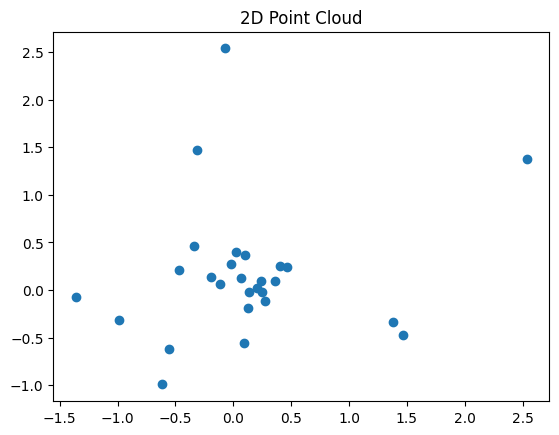

In [69]:
plt.figure()
plt.scatter(df['E2'][0][:,0], df['E2'][0][:,1])
plt.title('2D Point Cloud')
plt.show()

In [80]:
# Plot the persistence diagram and landscape for a random point cloud sliding window
pointcloud = df['E2'][0]

vrp = VietorisRipsPersistence()
plt.figure()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape))
plt.show()

pl = PersistenceLandscape()
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
fig = pl.plot(landscapedata, 
    homology_dimensions = [0], 
    plotly_params=None)
fig.show()

<Figure size 640x480 with 0 Axes>

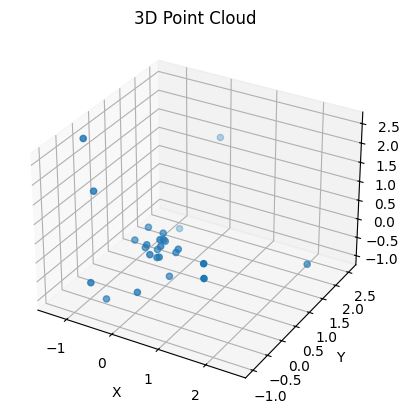

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['E3'][0][:, 0], df['E3'][0][:, 1], df['E3'][0][:, 2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Point Cloud')

plt.show()

In [78]:
pointcloud = df['E3'][0]

vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape))
plt.show()

pl = PersistenceLandscape()
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
fig = pl.plot(landscapedata, 
    homology_dimensions = [0], 
    plotly_params=None)
fig.show()

In [23]:
# Functions to compute the Lp norms
# Find the range of x values from the persistence diagram:
def Ftseq(diagram):
    births =[]
    deaths =[]
    for pair in diagram:
        if pair[2] == 1:
            births.append(pair[0])
            deaths.append(pair[1])
    return np.linspace(min(births), max(deaths), 100)

# Calculate Lp norm:
def Lpnorm(tseq, landscapevalues, p = 1):
    norms = []
    if p == 'aucoriginal':
        layervalues = landscapevalues[layers]
        for point in zip(tseq,layervalues):
            norms.append(np.trapz(layervalues, tseq))
        return(sum(norms))
    elif p == 'aucUpdated':
        layervalues = landscapevalues[layers]
        return (np.trapz(layervalues))
    else:
        normvalues = []
        for layer in range(layers, 2*layers):
            layervalues = landscapevalues[layer]
            normvalue = np.linalg.norm(layervalues,p)**p
            if normvalue == 0:
                break
            else: 
                normvalues.append(normvalue)
        return (np.sum(normvalues)**(1/p))

## Compute the L1 Norms

In [26]:
layers = 10
vrp = VietorisRipsPersistence()
pl = PersistenceLandscape(layers)

for e in tqdm(range(2,10), desc = "Window Sizes", unit="e"):
    Norms = []
    for pointcloud in tqdm(df['E{}'.format(e)], desc="Computing norms", unit="cloud"):
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        Norm = Lpnorm(tseq, landscapedata[0], p = 1)
        Norms.append(Norm)
    df['N{}'.format(e)] = Norms


Window Sizes:   0%|          | 0/8 [00:00<?, ?e/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

Computing norms:   0%|          | 0/284807 [00:00<?, ?cloud/s]

In [27]:
df.to_csv('data.csv')

In [28]:
df = pd.read_csv('data.csv')

In [29]:
df['Class'] = df['Class'].astype(str)

## (Welch's) t test on whether difference in means of each variable is significant

In [30]:
def t_test(df, col, class_col='Class', group_labels=('0', '1'), alpha=0.05):
    group_0 = df[df[class_col] == group_labels[0]][col]
    group_1 = df[df[class_col] == group_labels[1]][col]

    # Test for equal variances
    _, p_var = levene(group_0, group_1)
    equal_var = p_var > alpha  # If p > alpha, variances are similar

    # Perform t-test with appropriate assumption
    t_stat, p_val = ttest_ind(group_0, group_1, equal_var=equal_var)

    return {
        'column': col,
        'equal_var_assumed': equal_var,
        'variance_test_p_value': p_var,
        't_statistic': t_stat,
        'p_value': p_val,
        'significant': p_val < alpha
    }

# Example usage:
result = t_test(df, 'N2')
print(result['p_value'])


1.7631441634964828e-32


## L1 Norms obtained via sliding window embeddings of PCA vectors surprisingly have significant effect on response variable

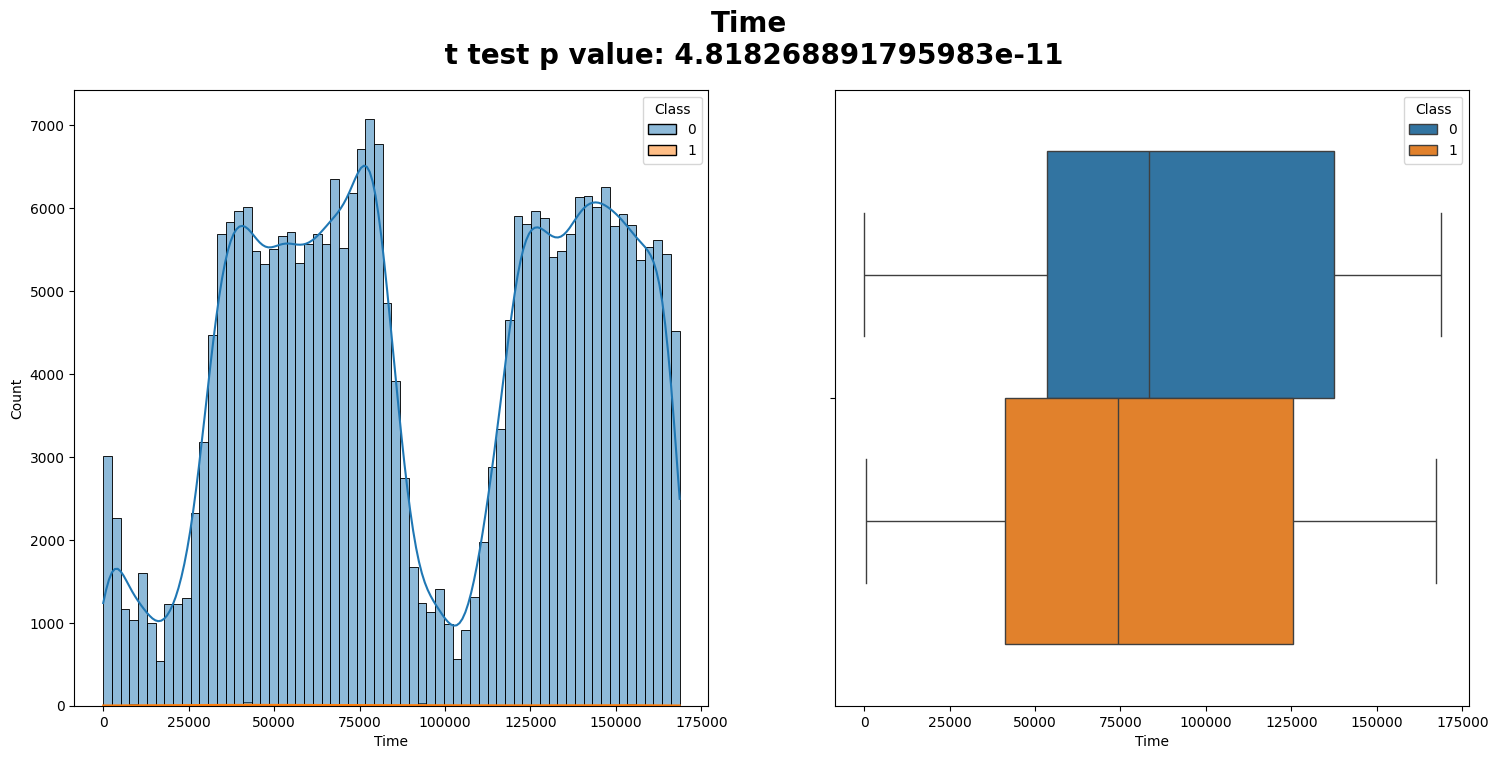

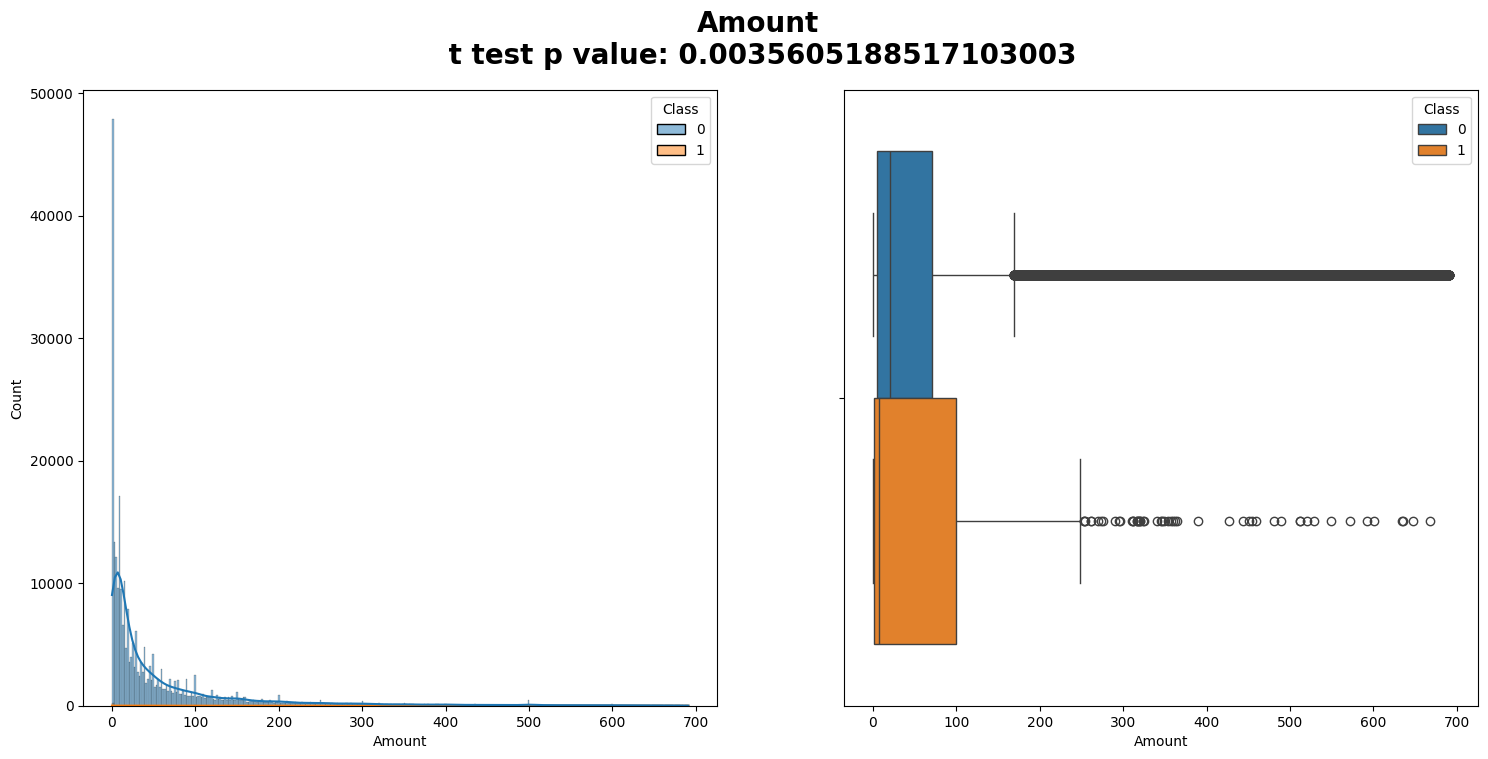

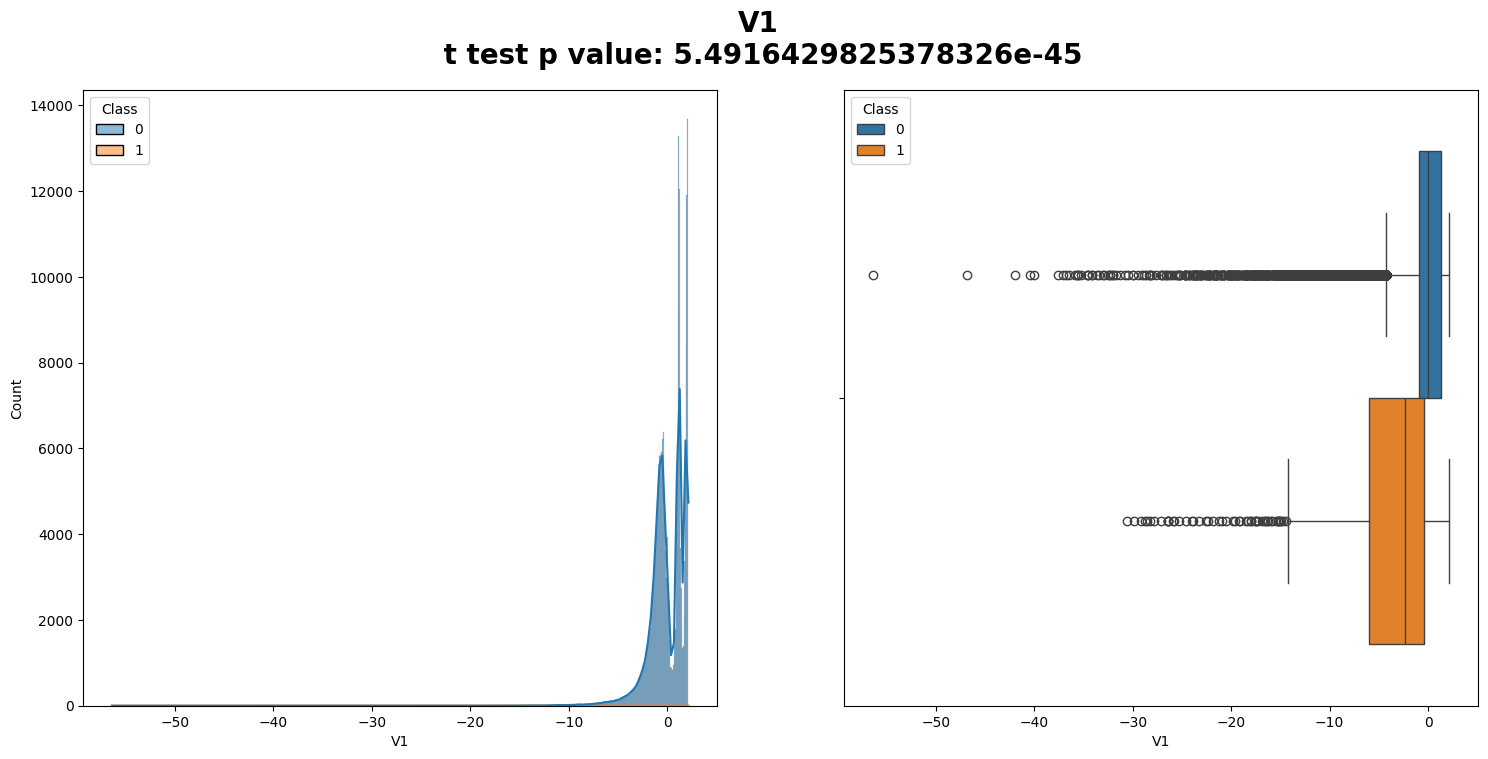

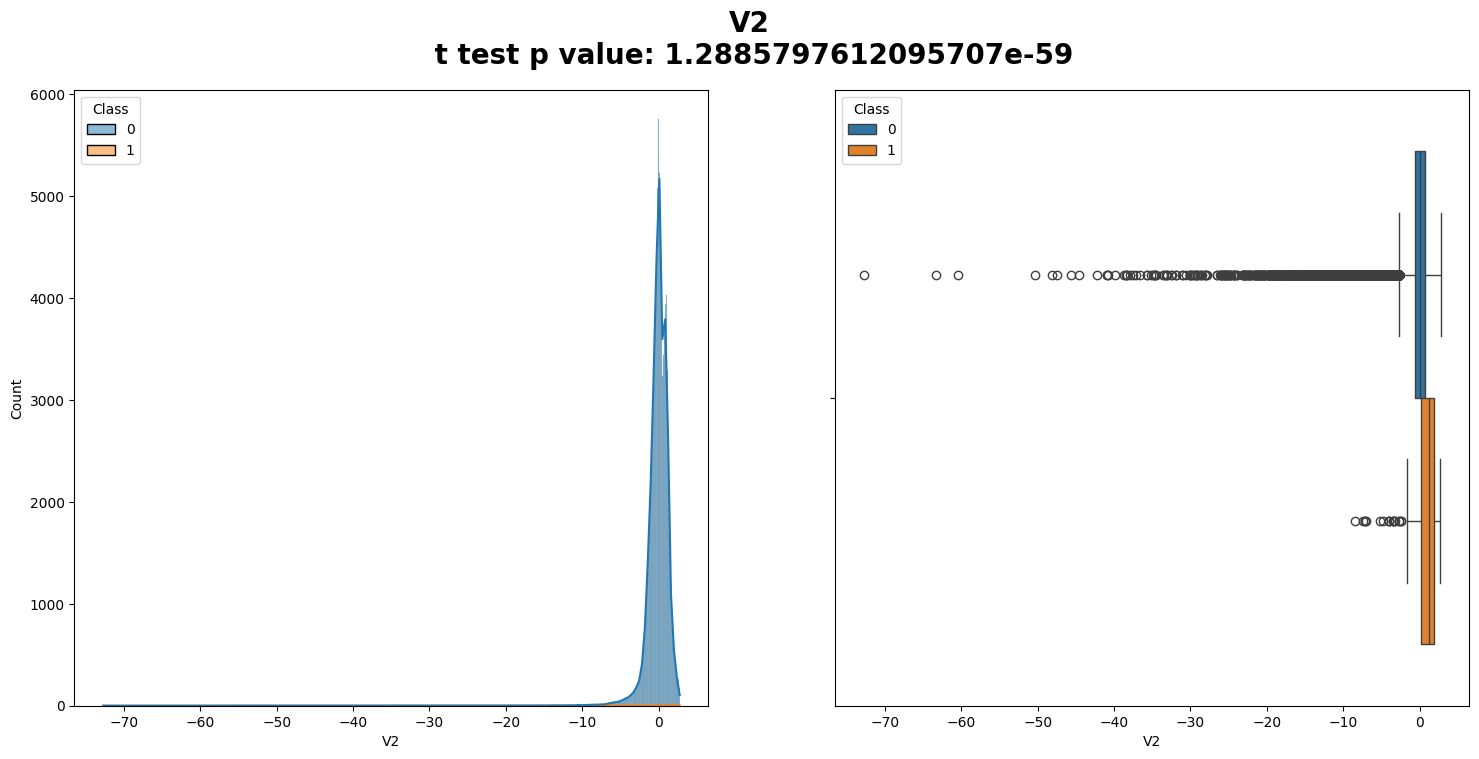

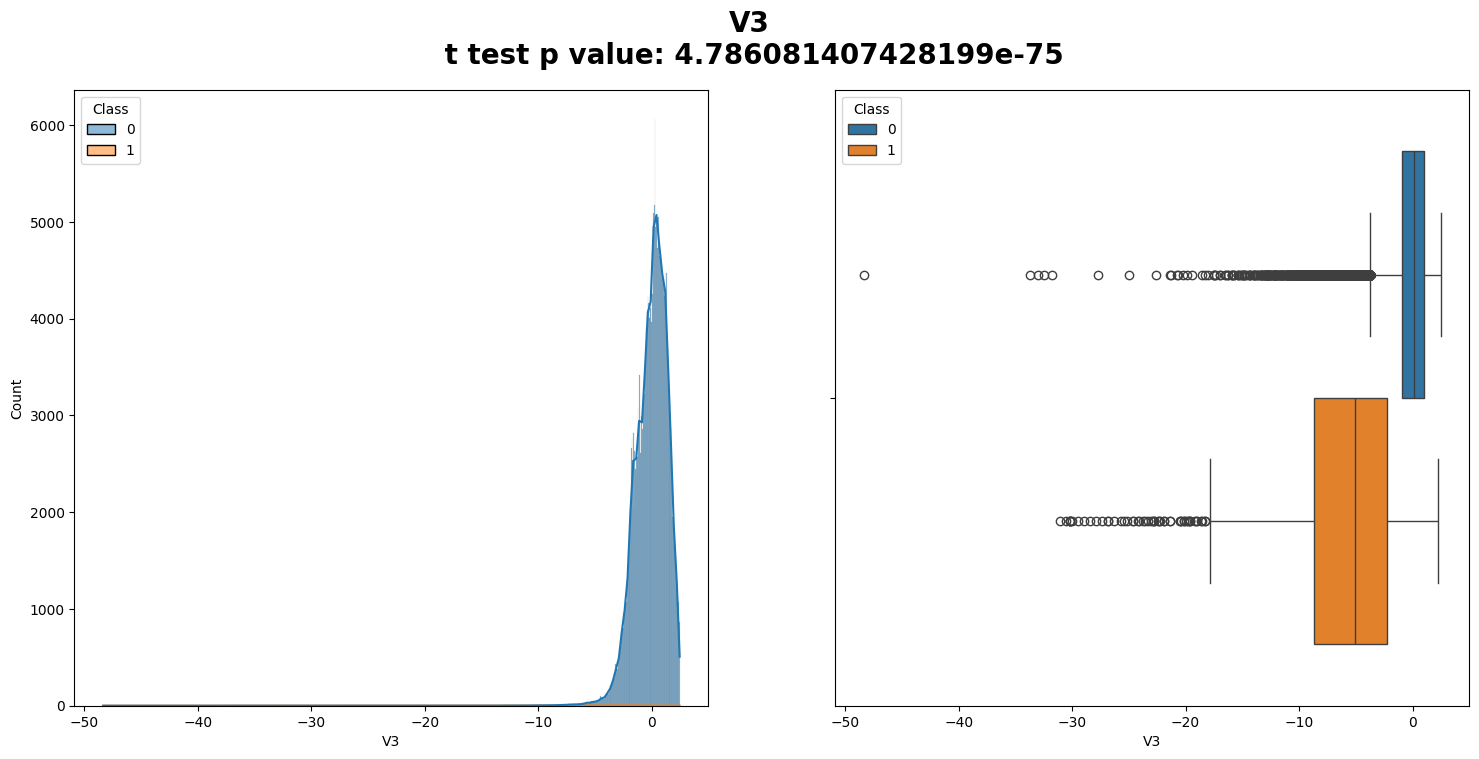

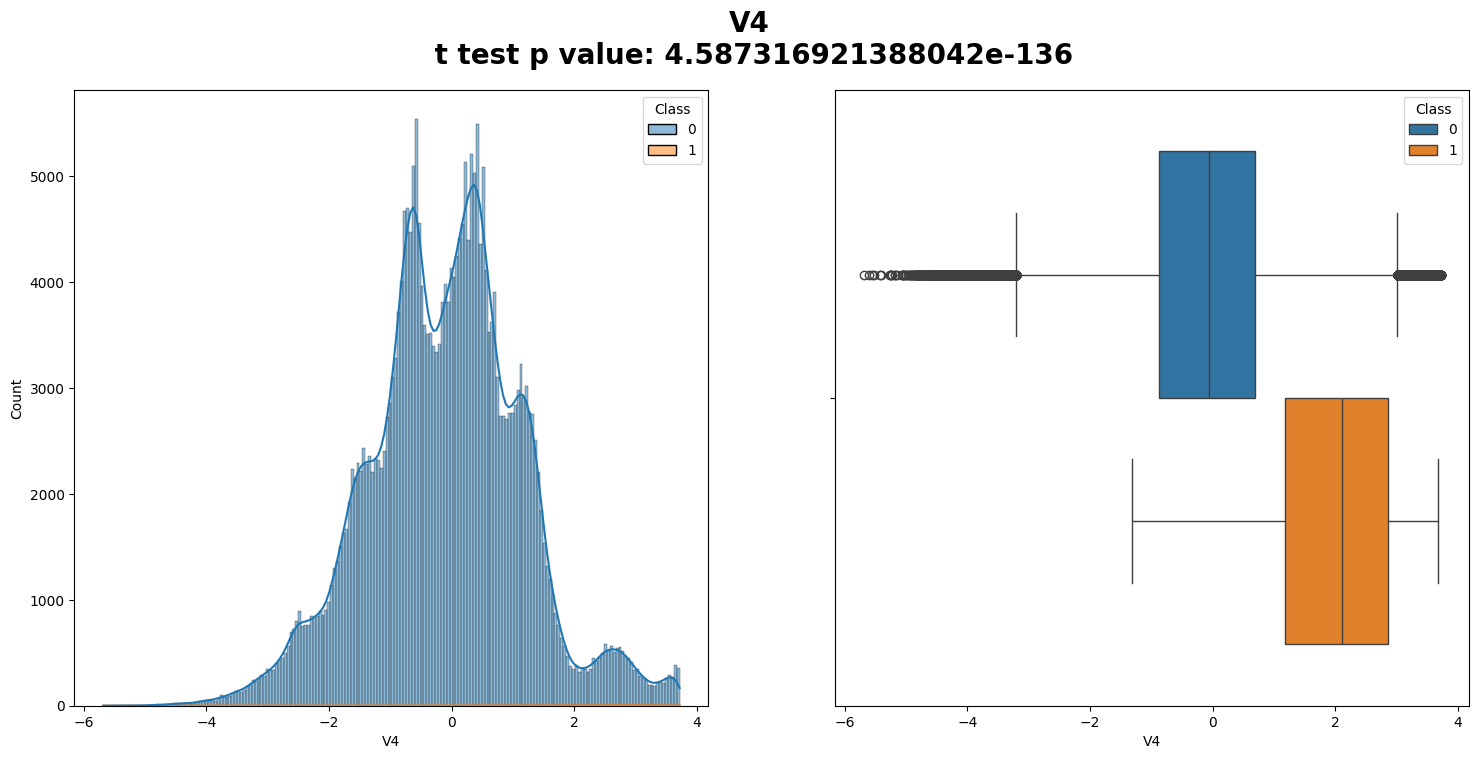

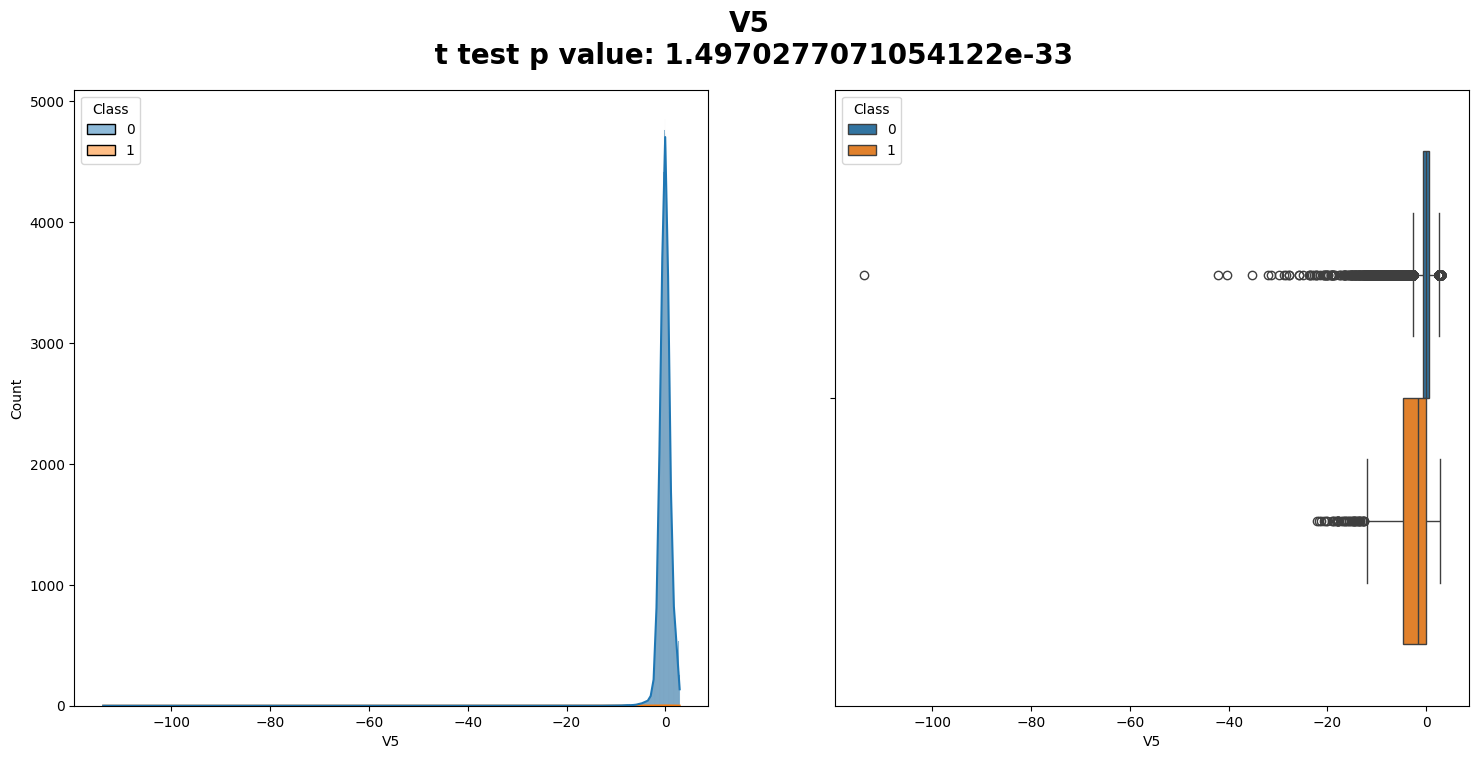

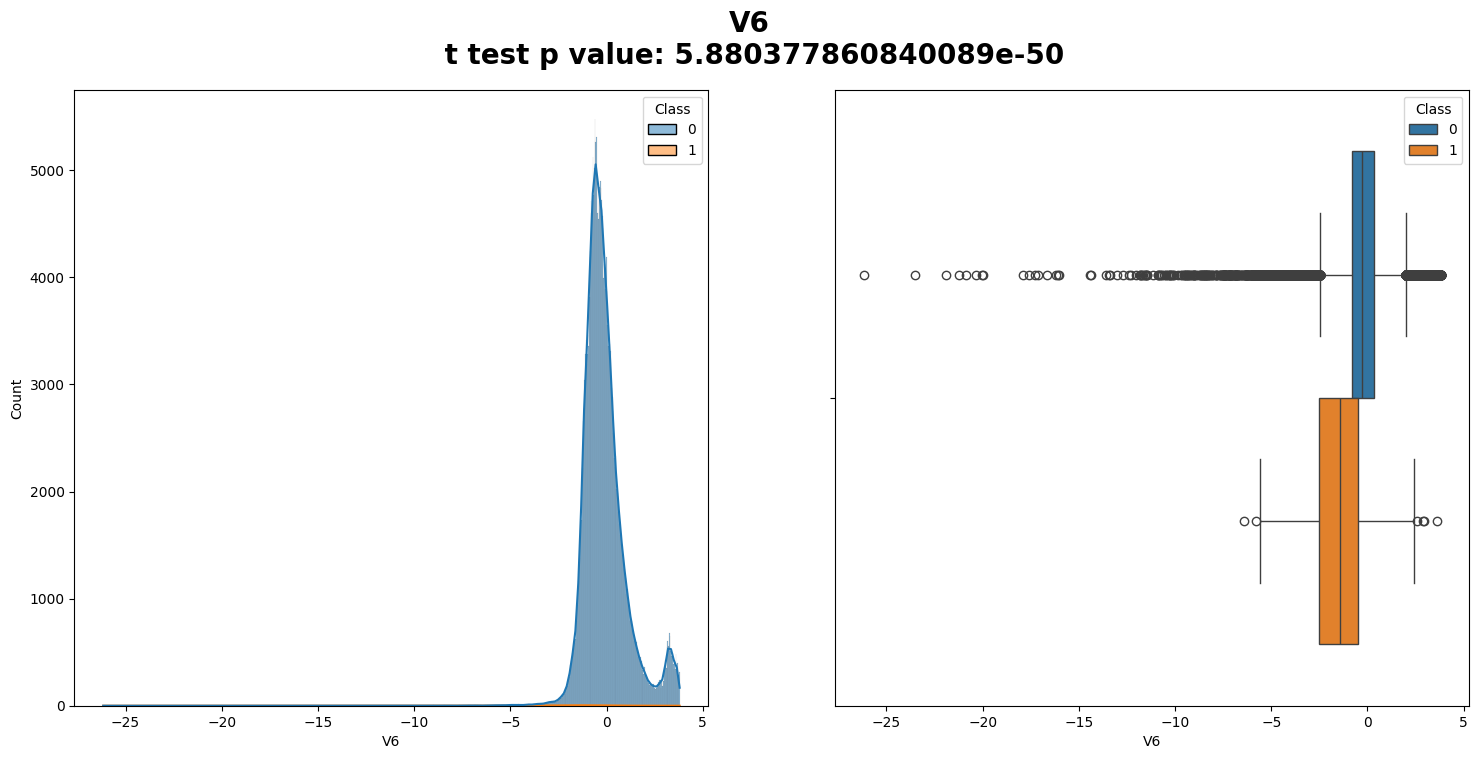

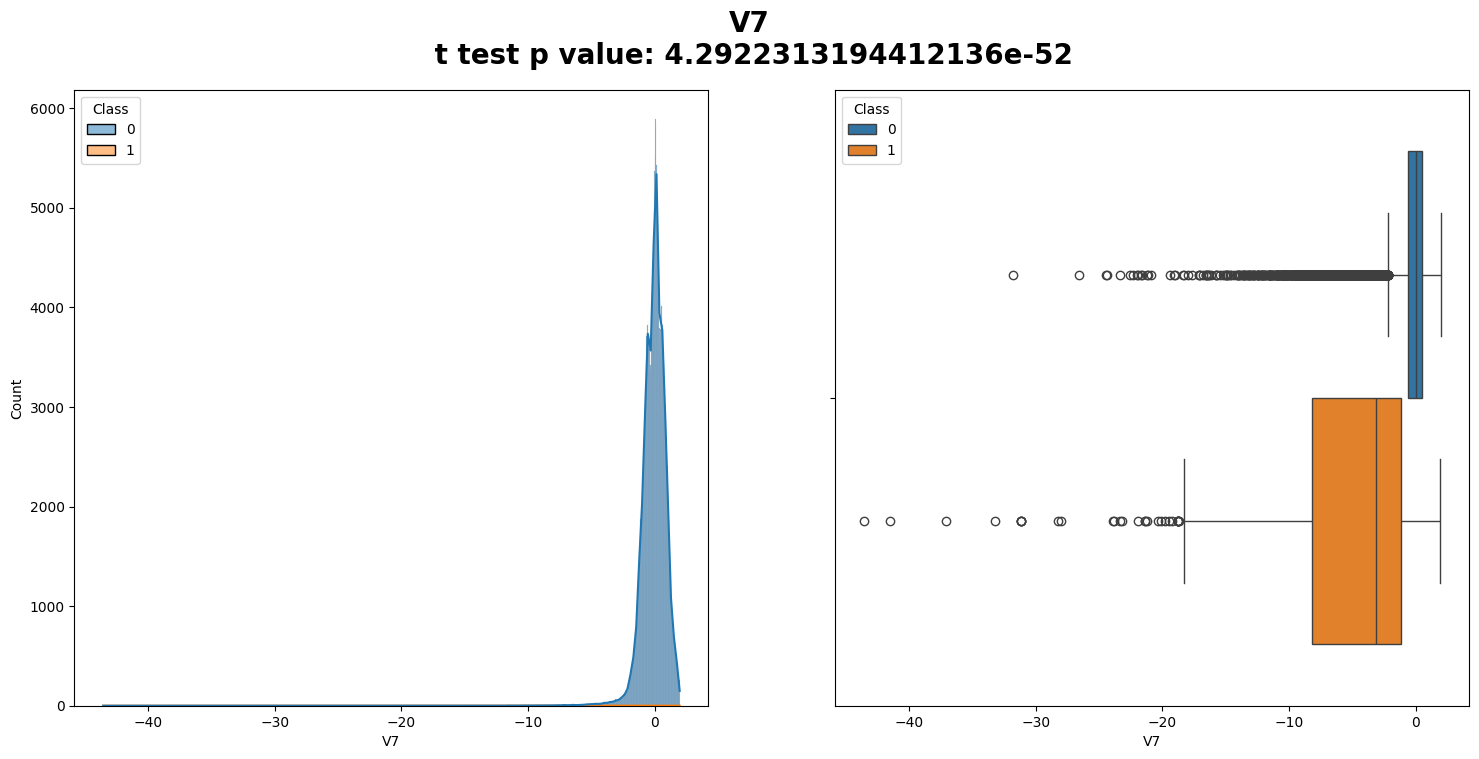

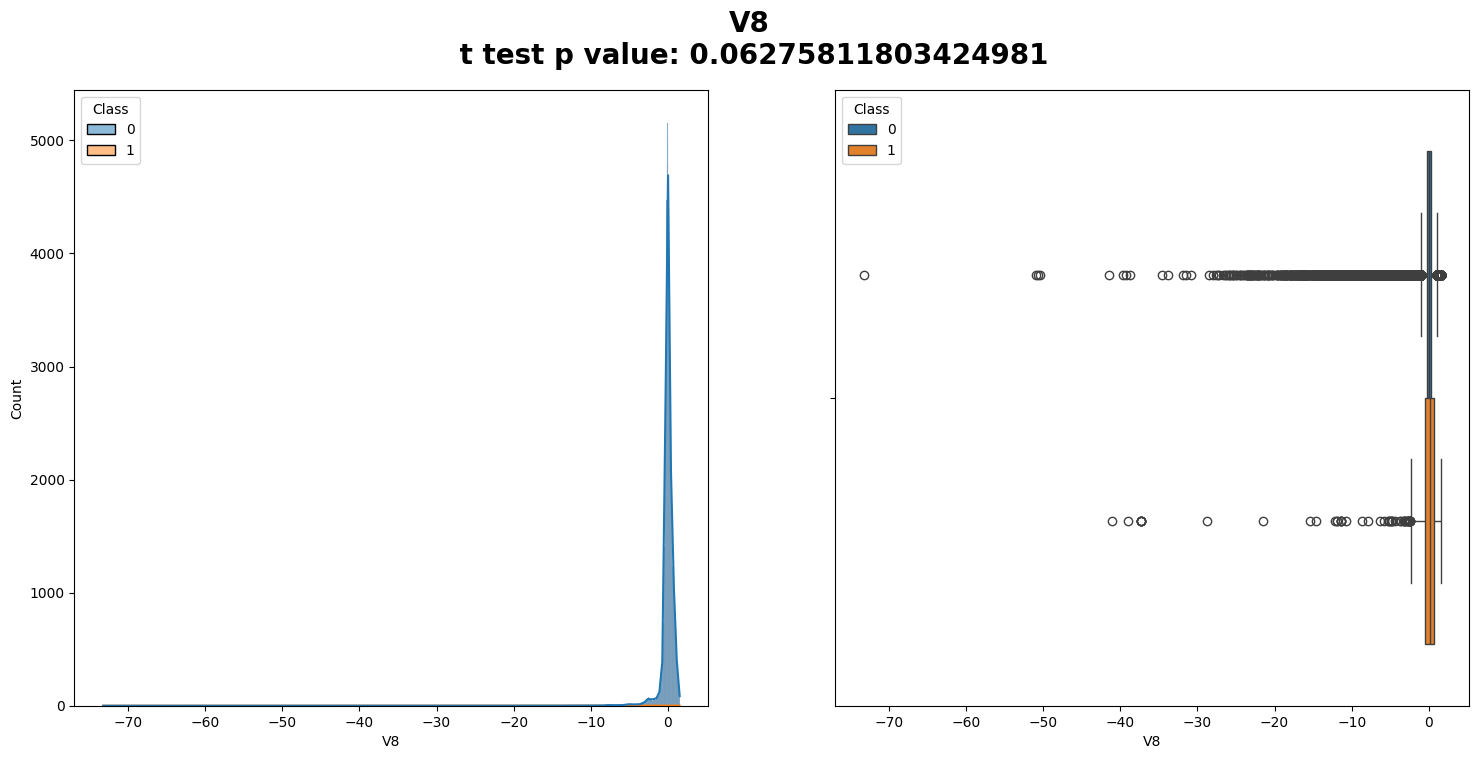

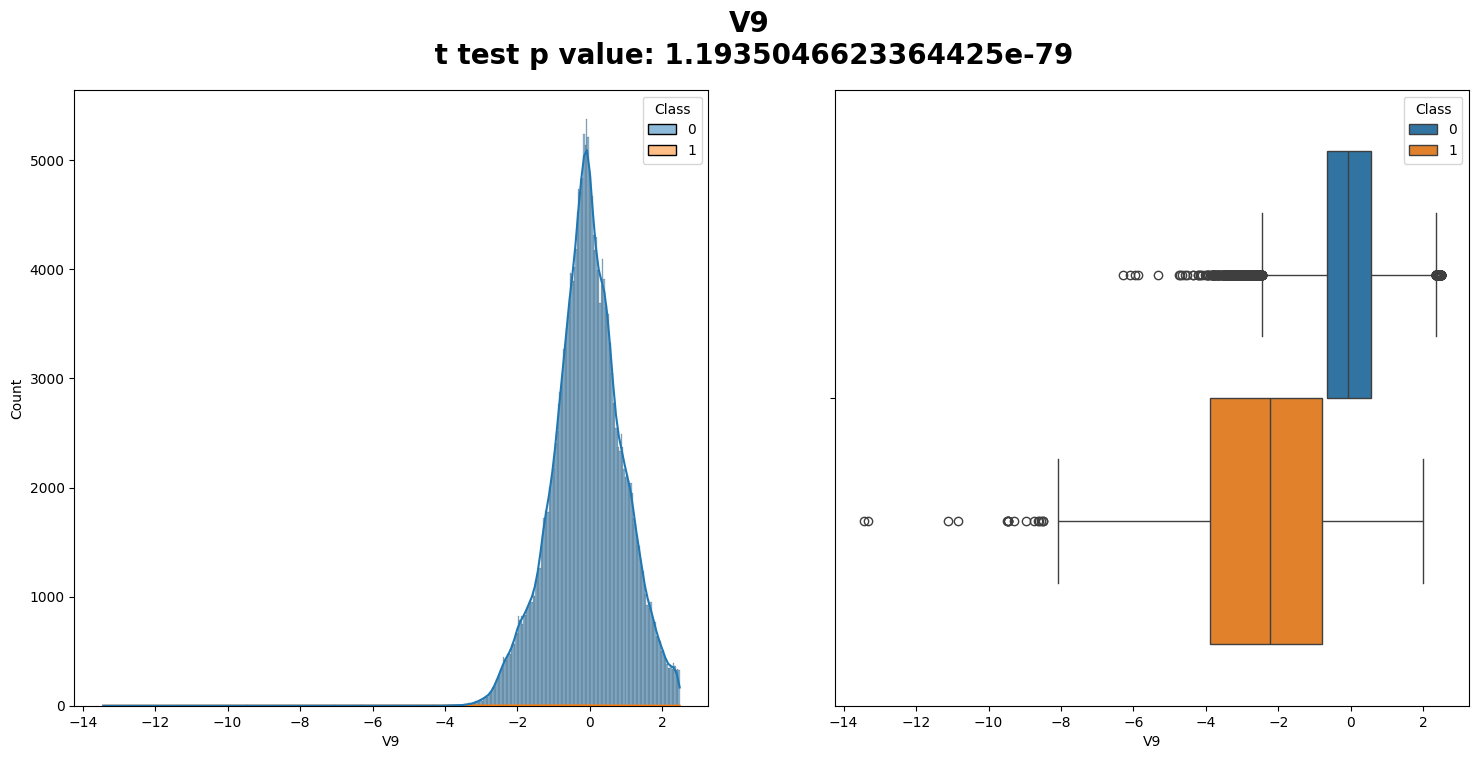

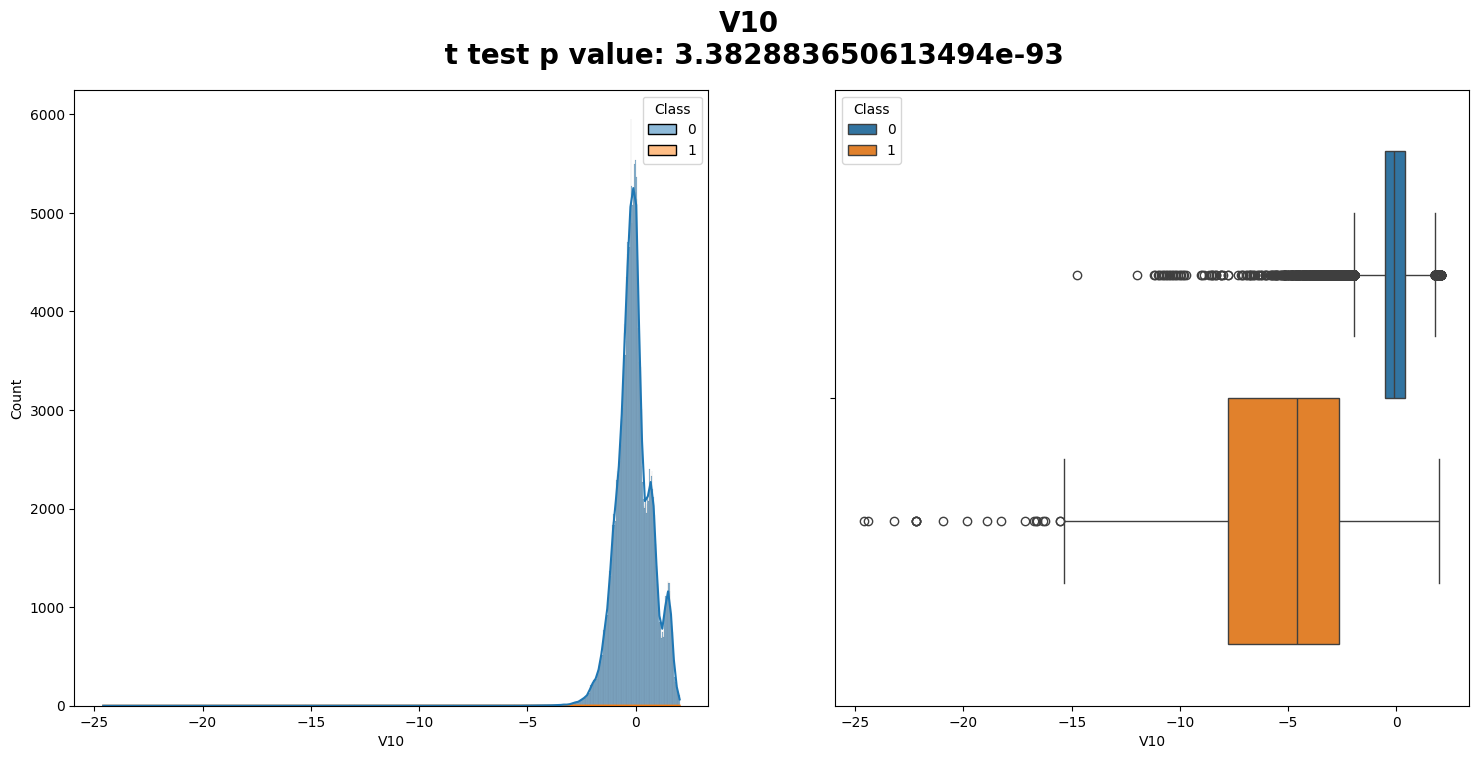

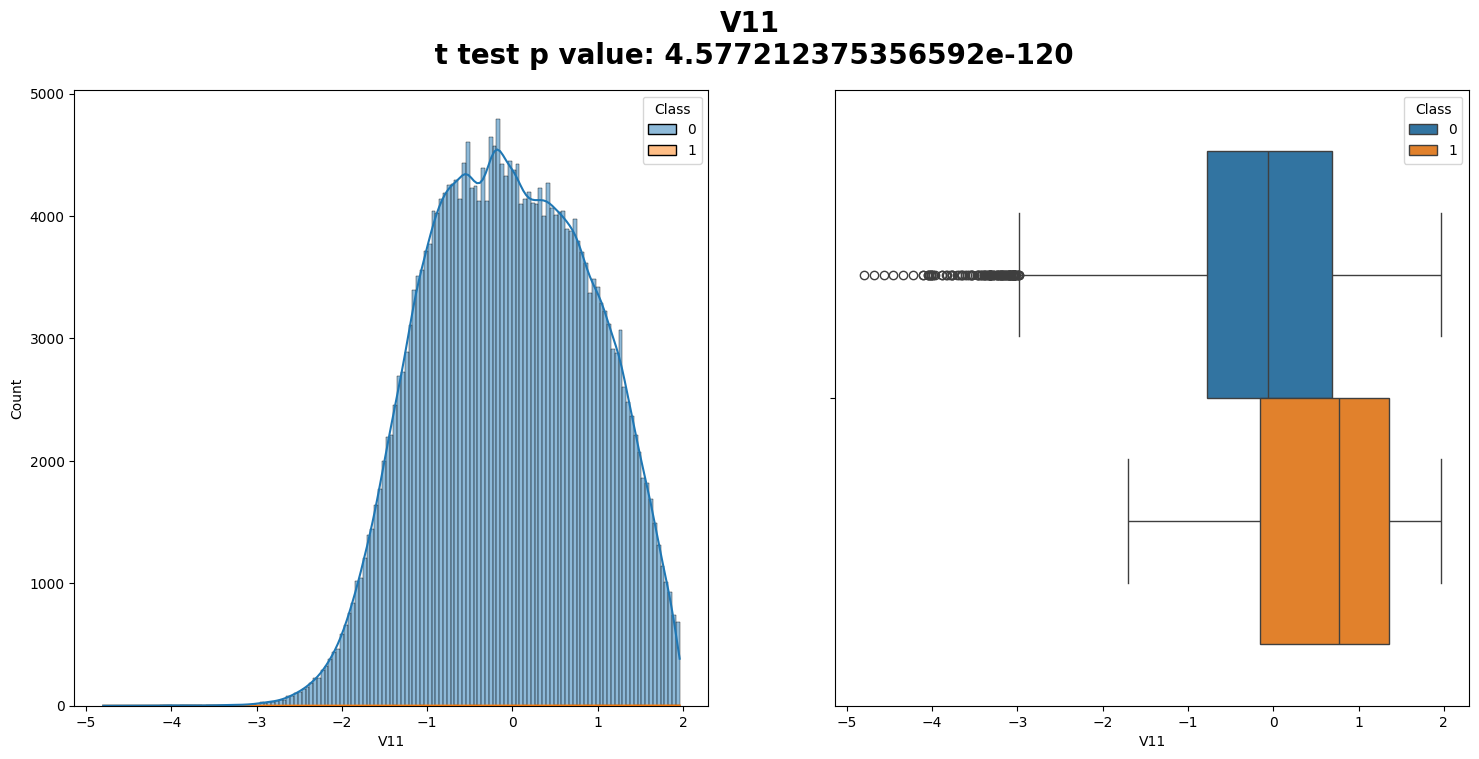

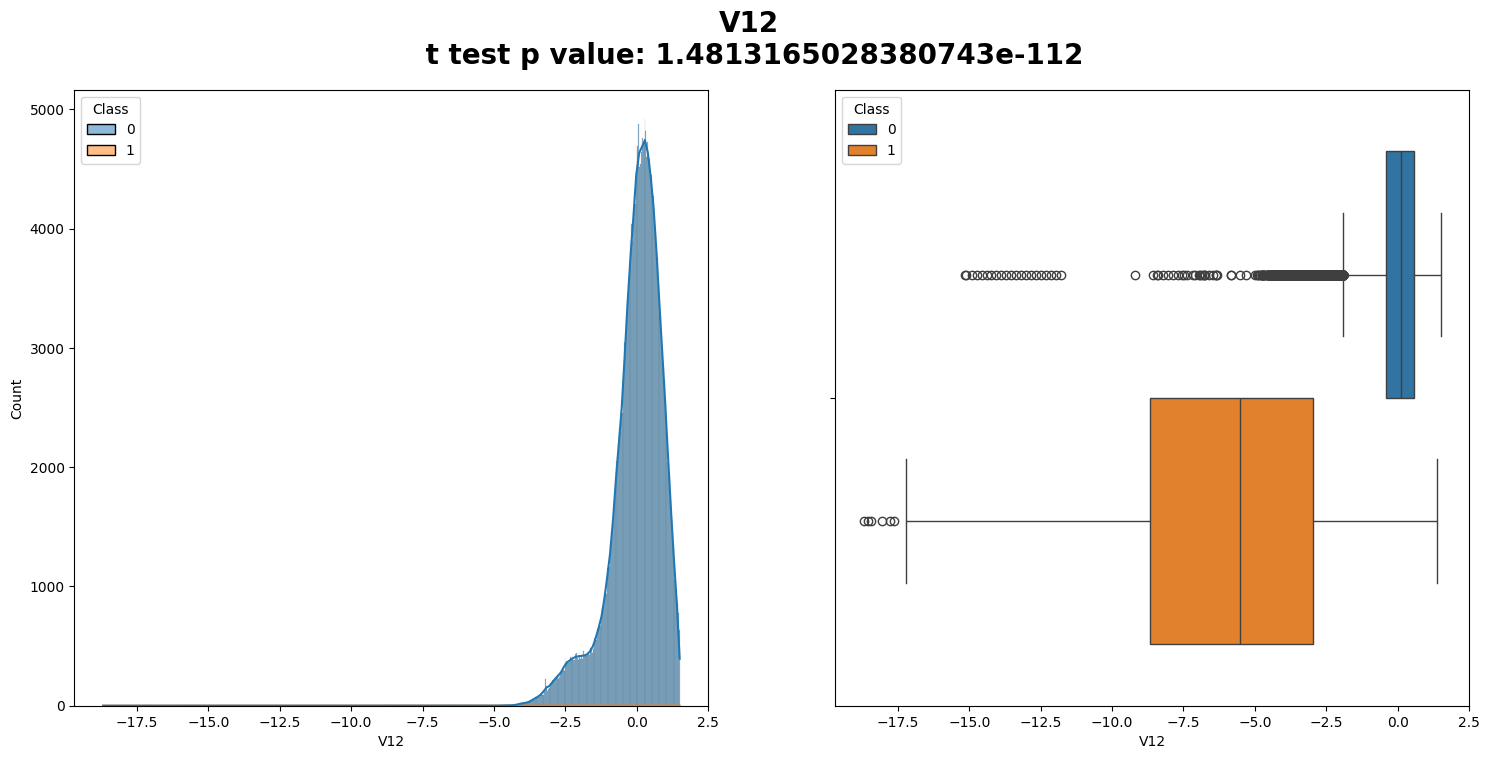

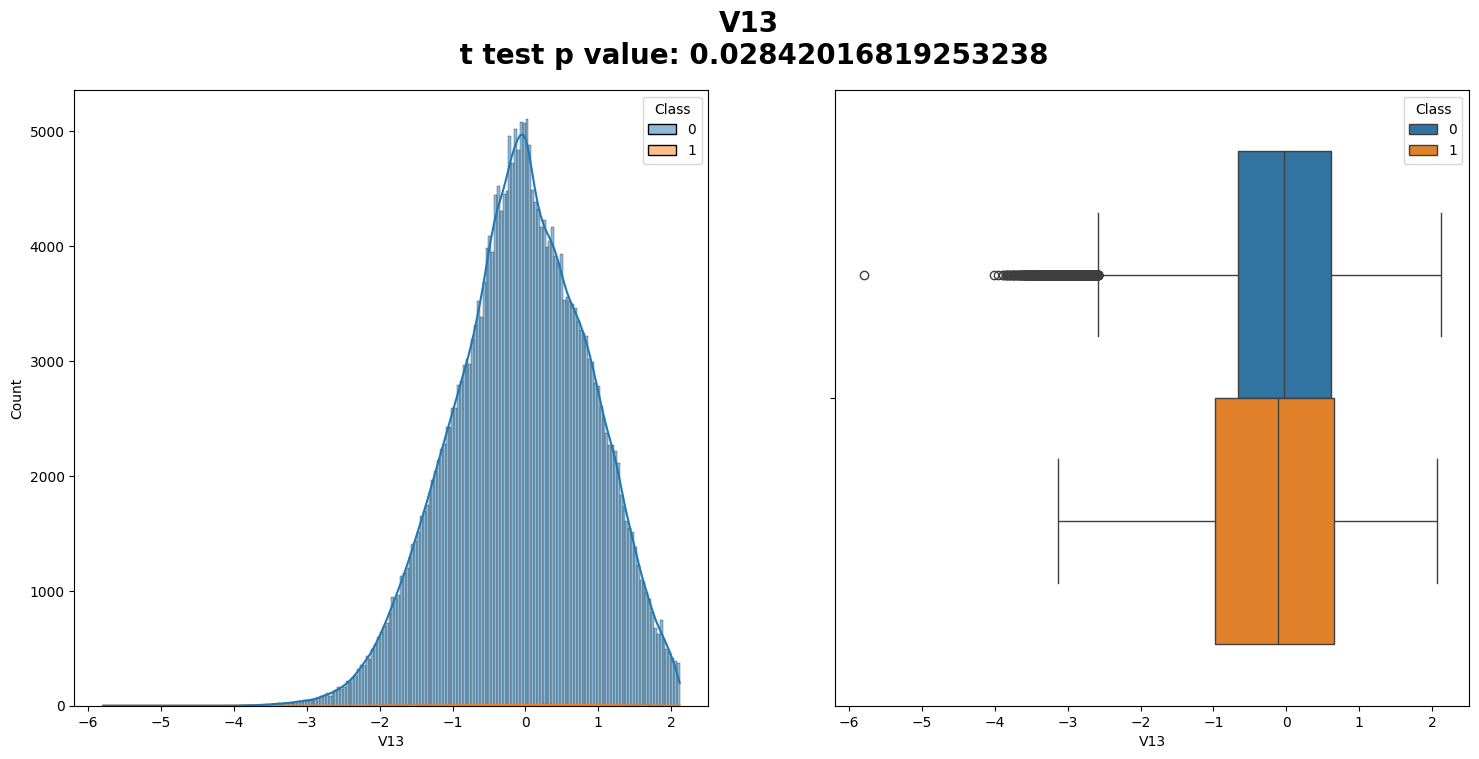

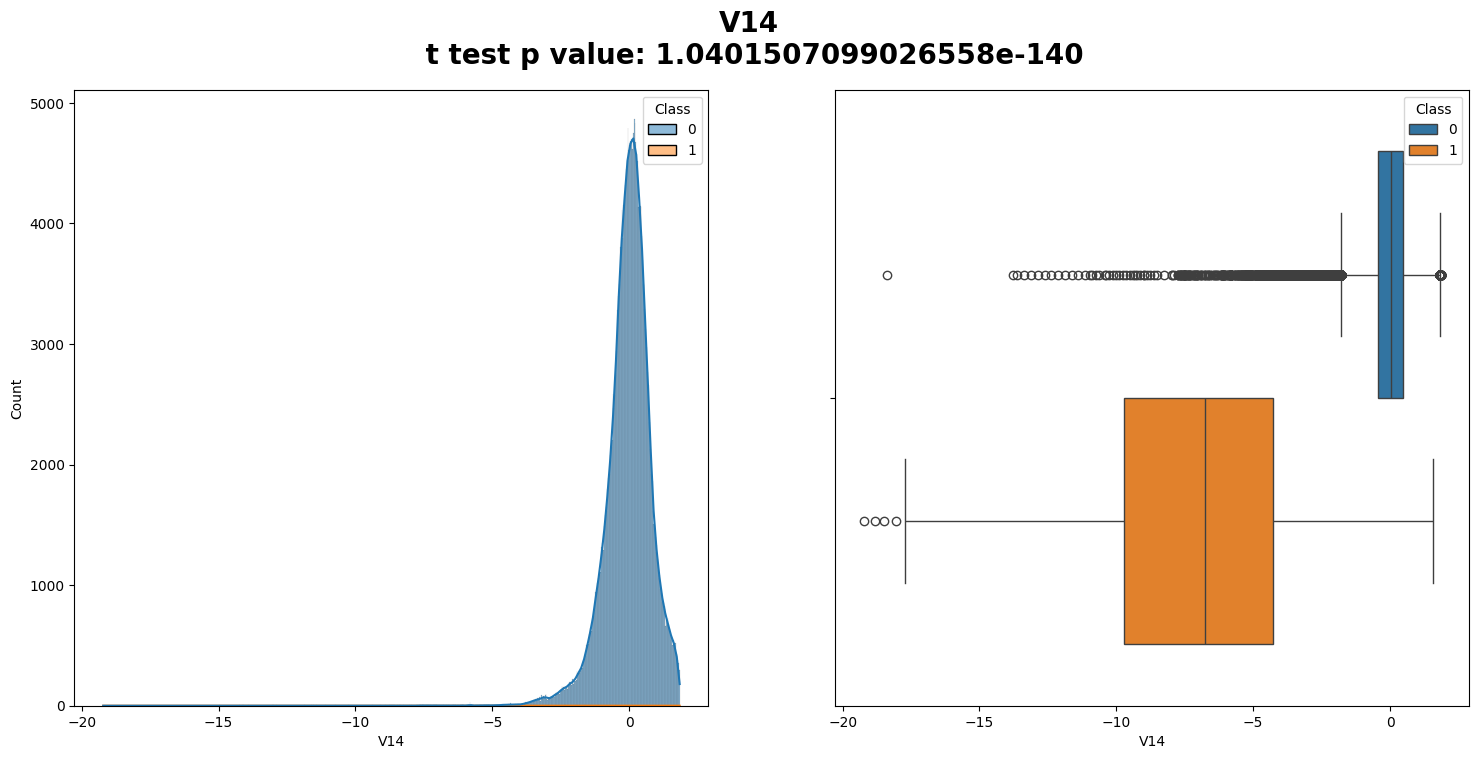

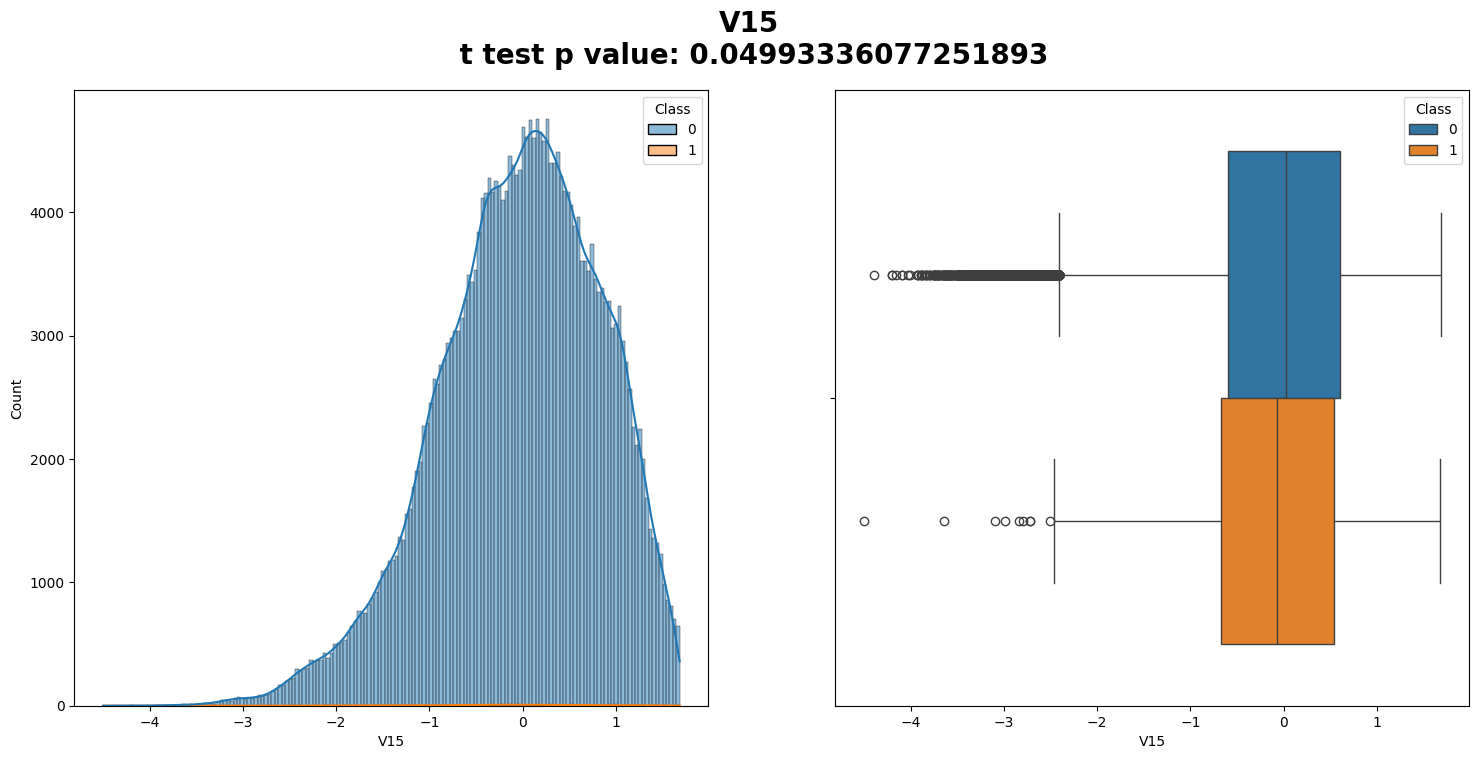

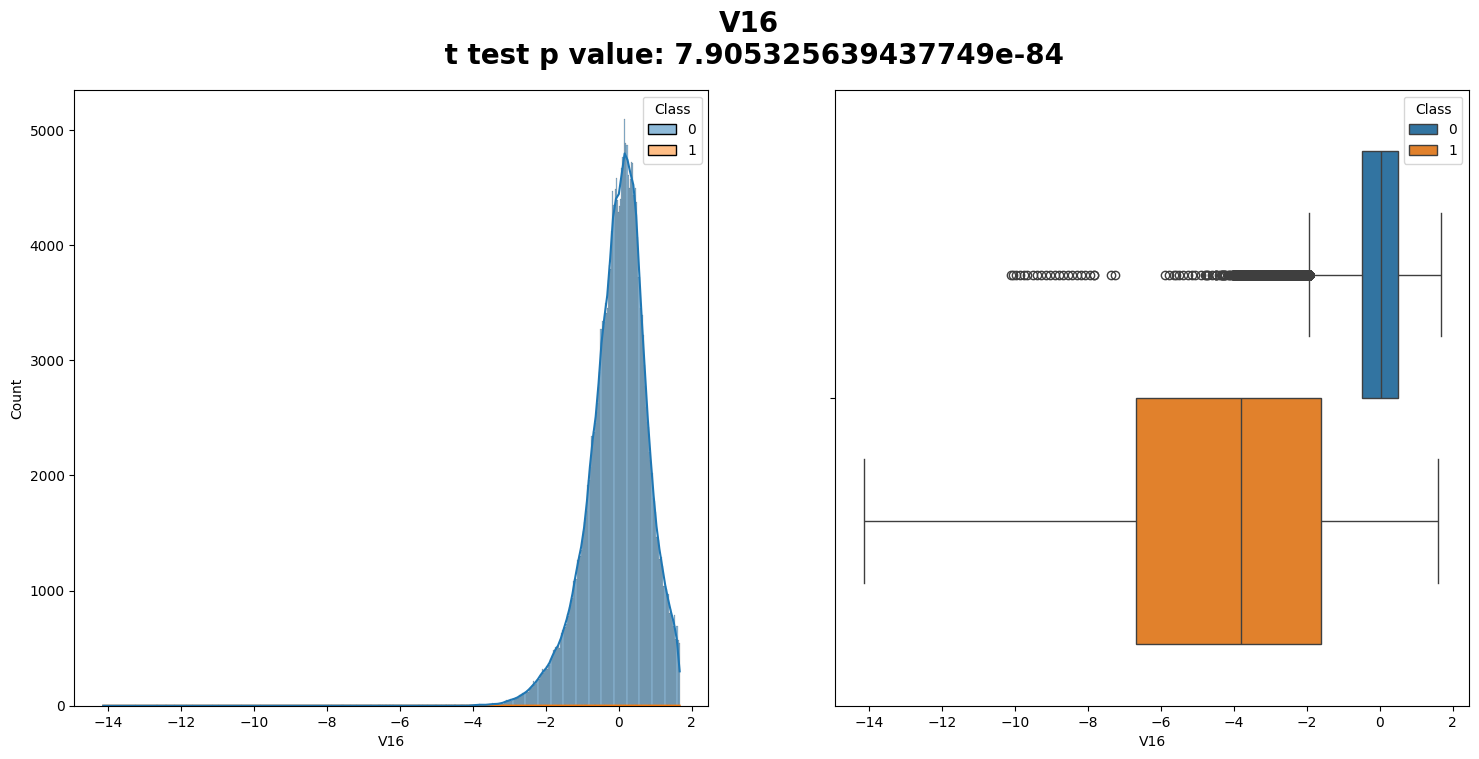

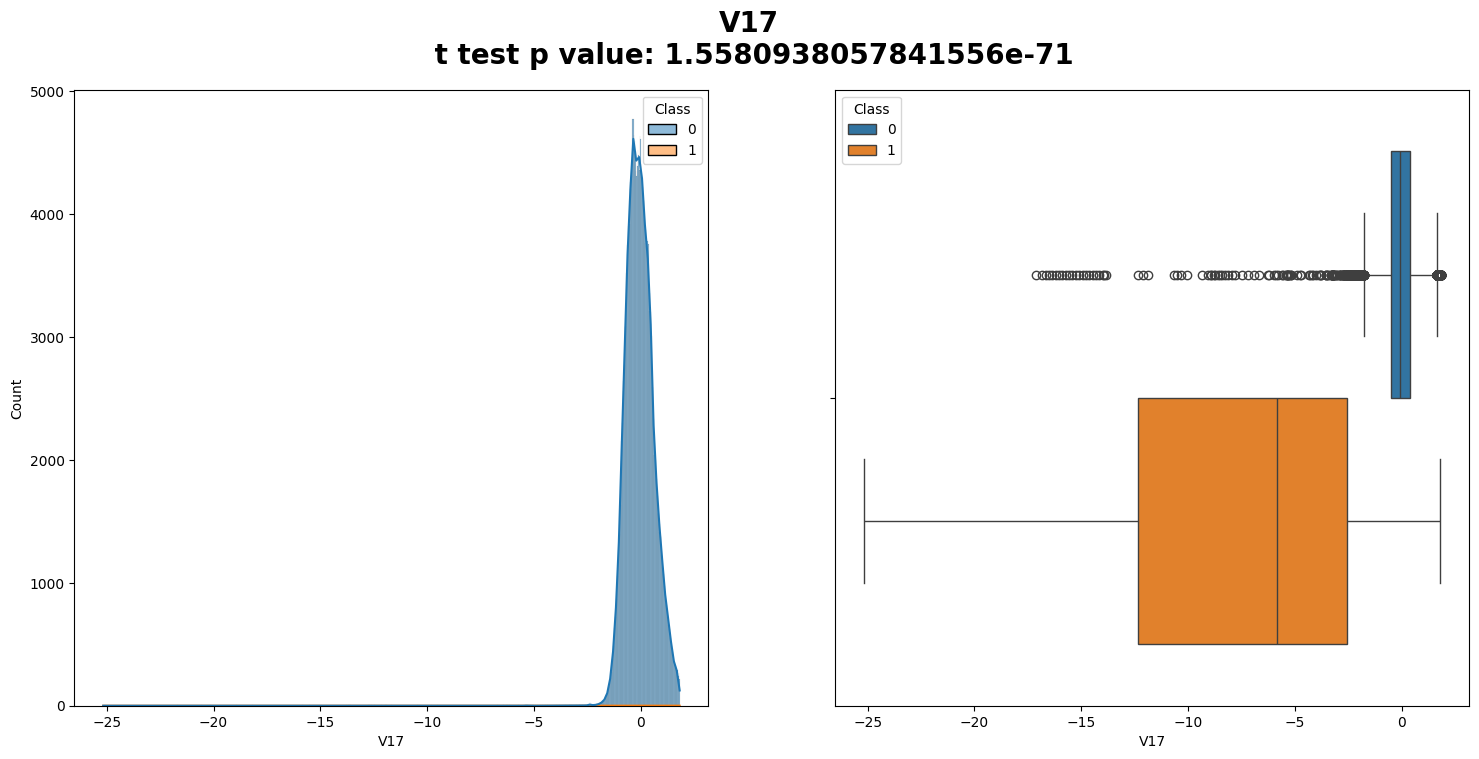

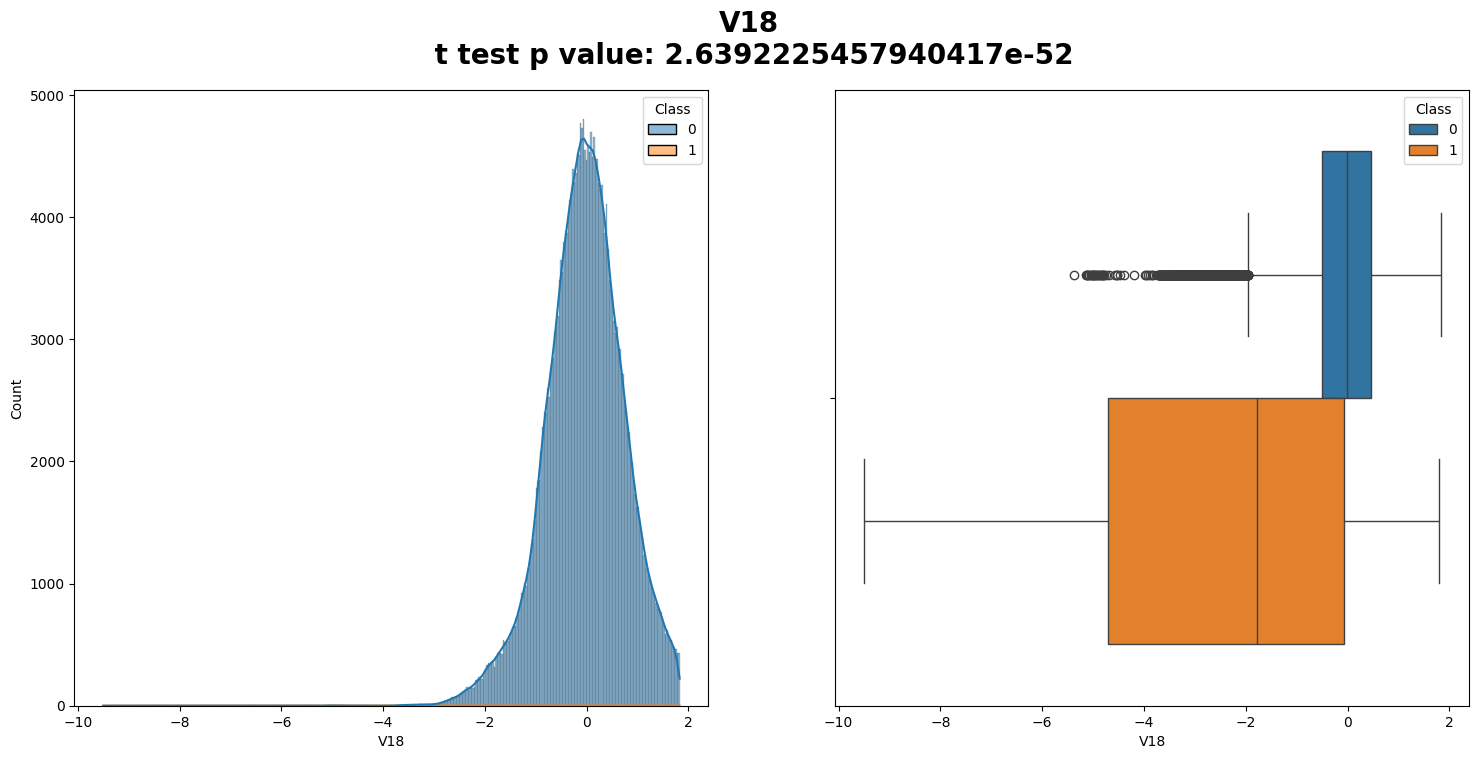

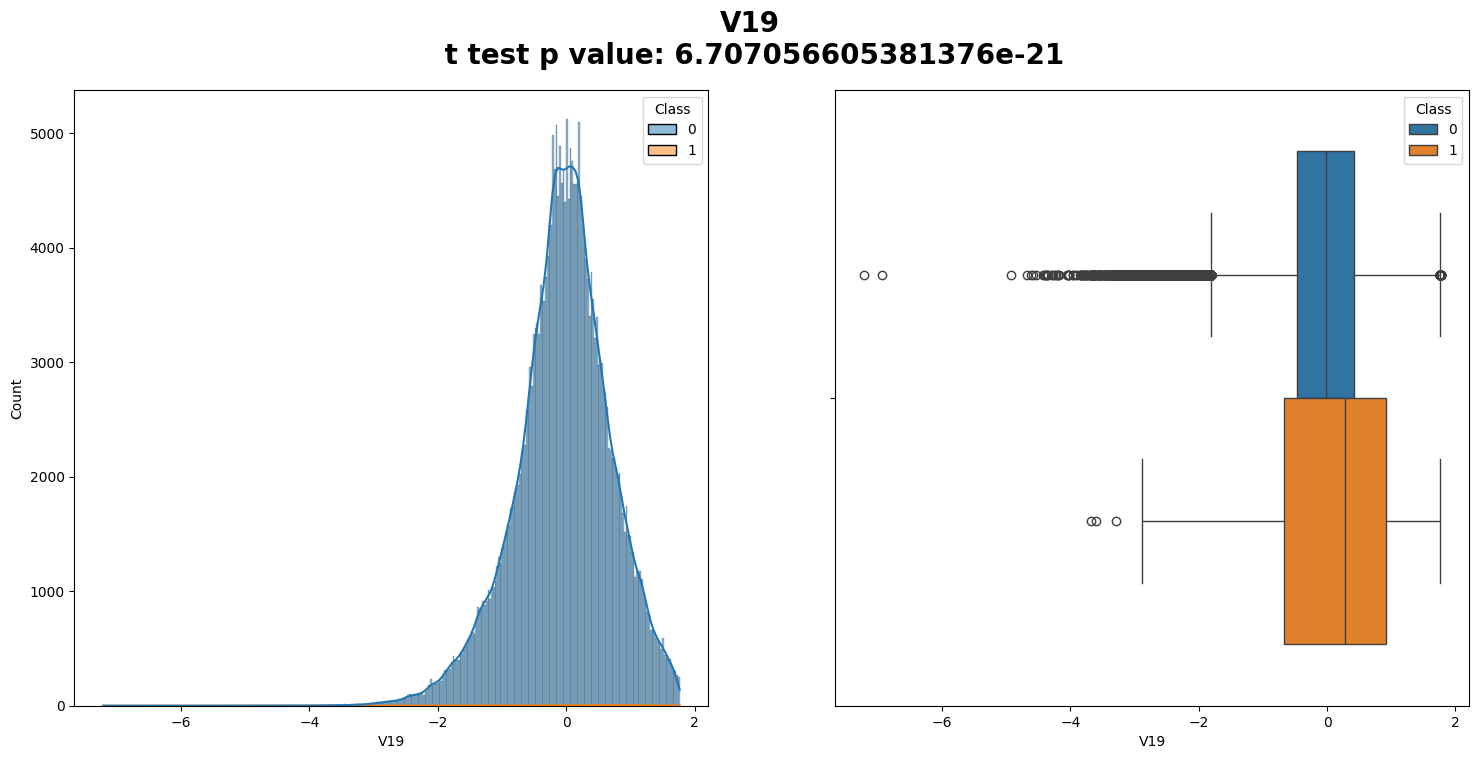

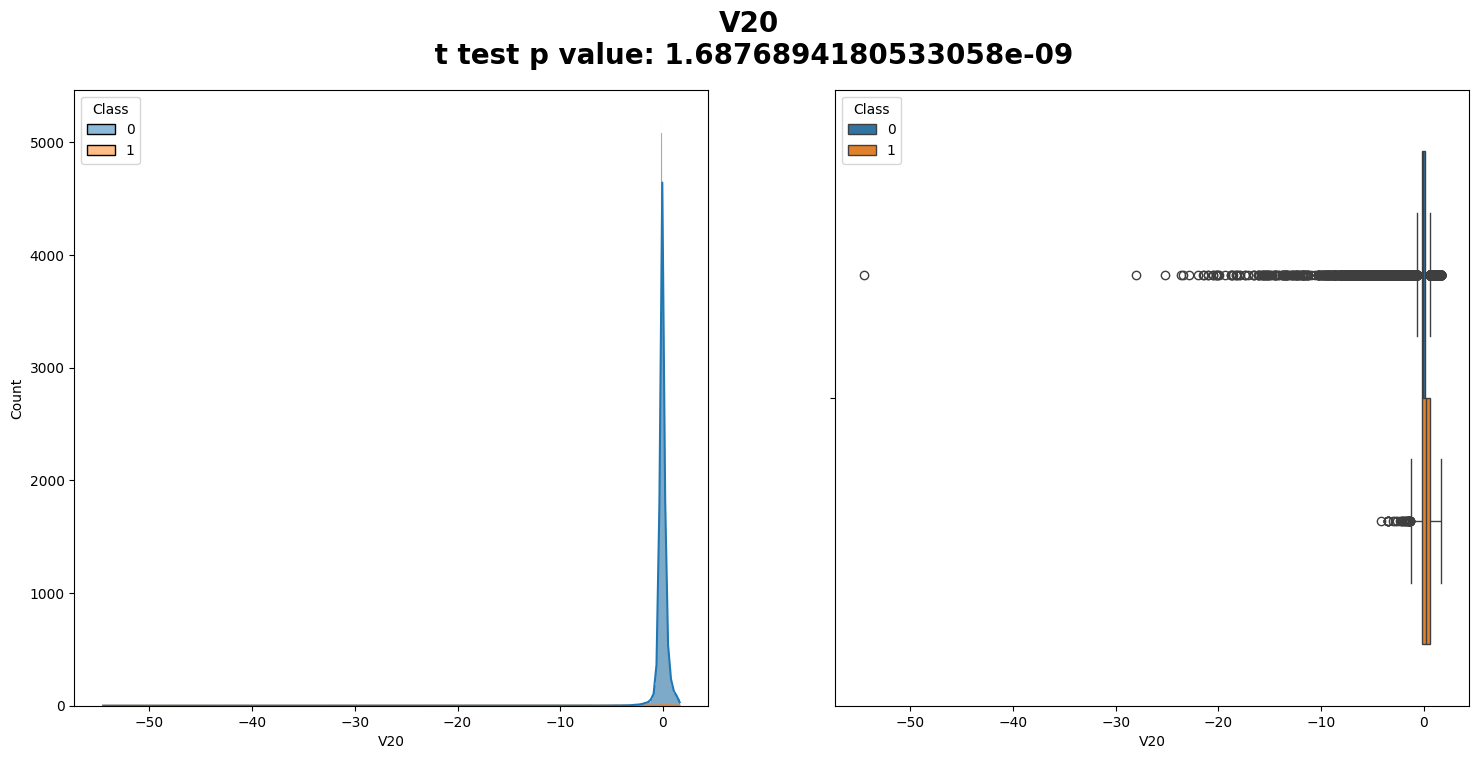

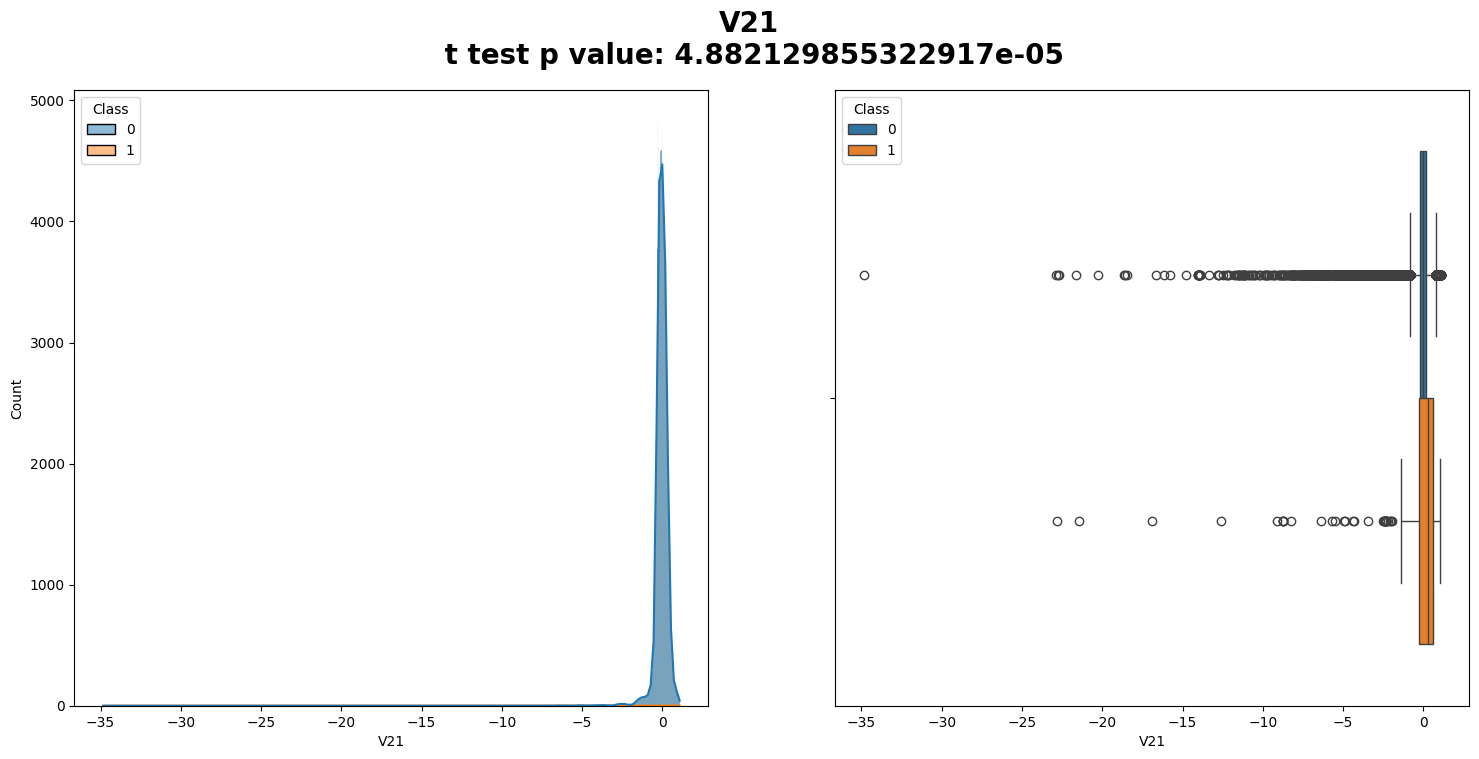

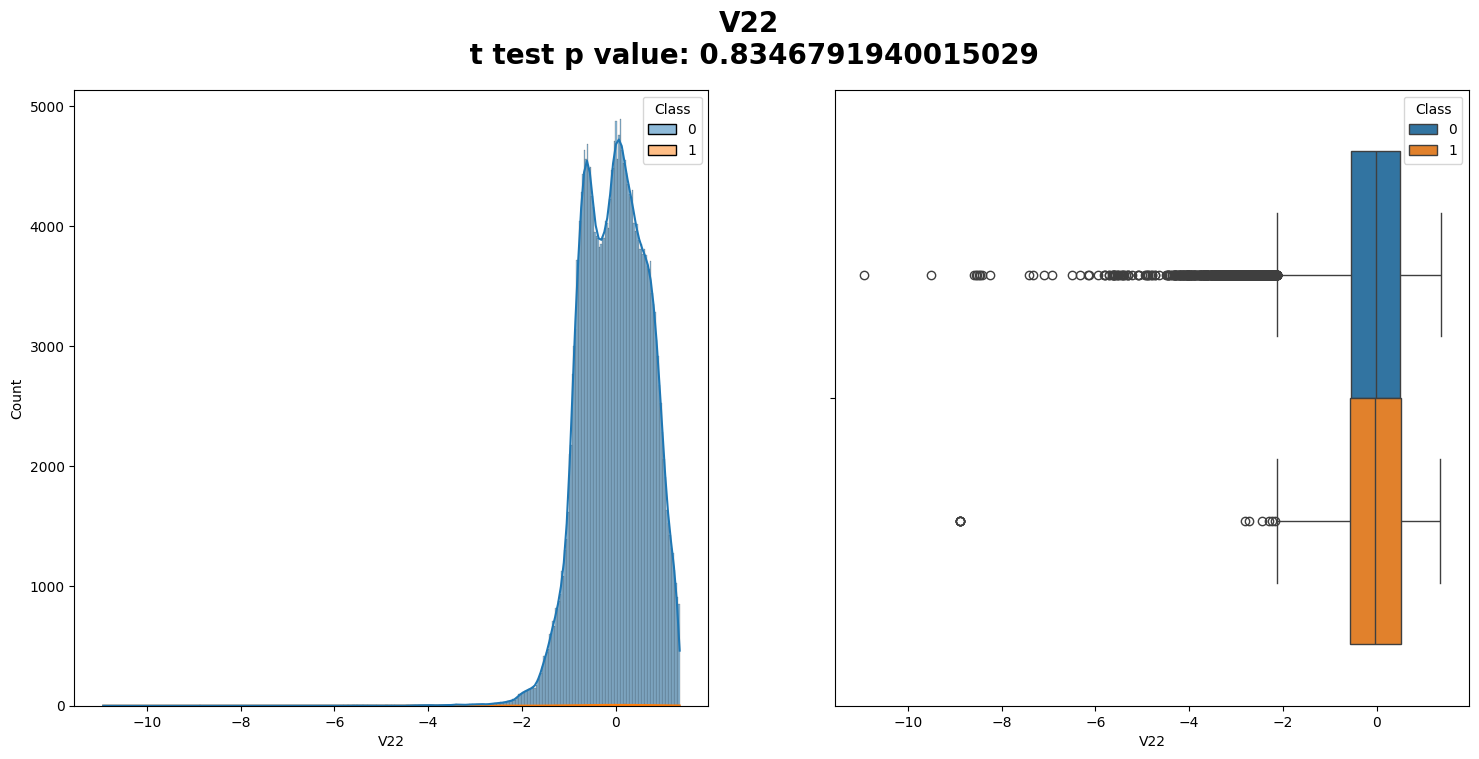

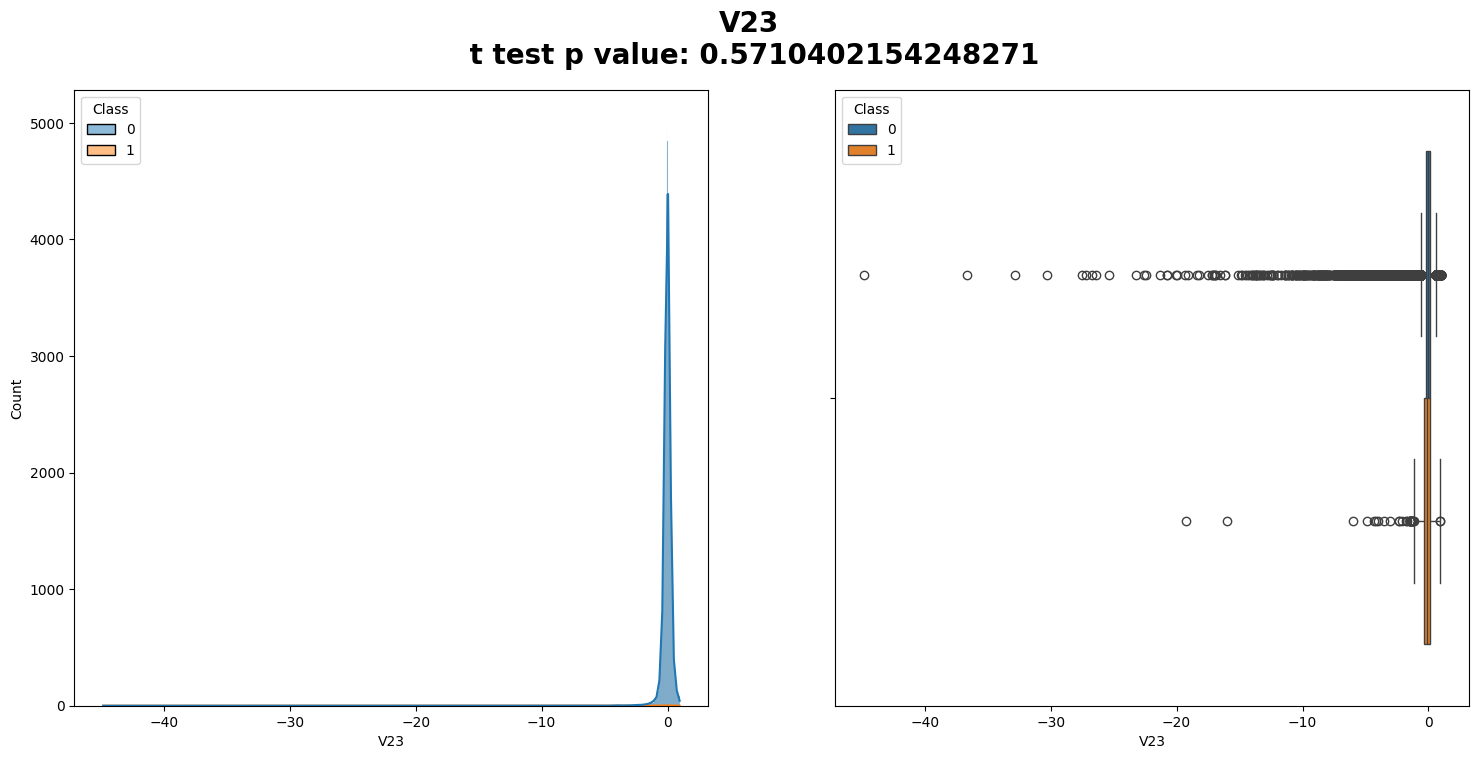

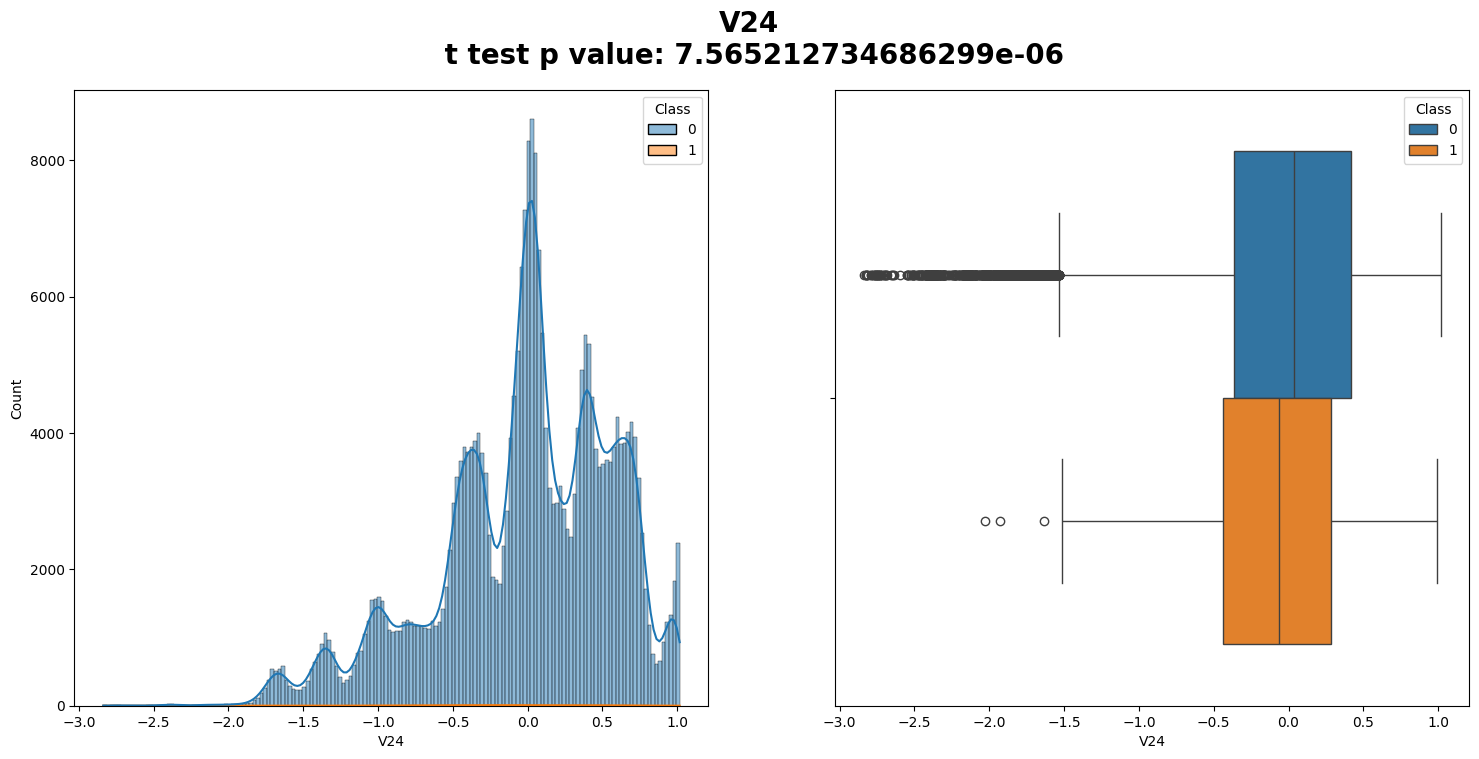

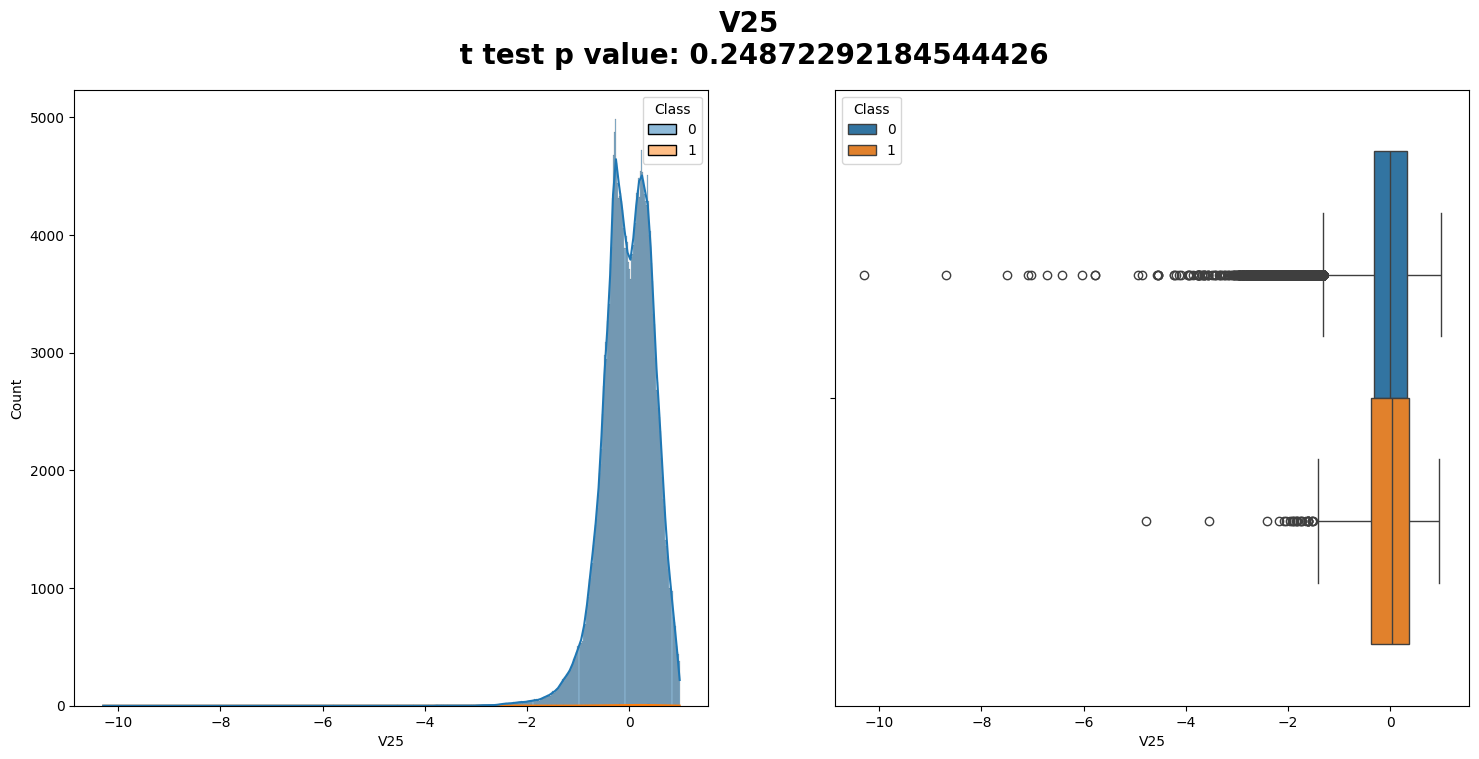

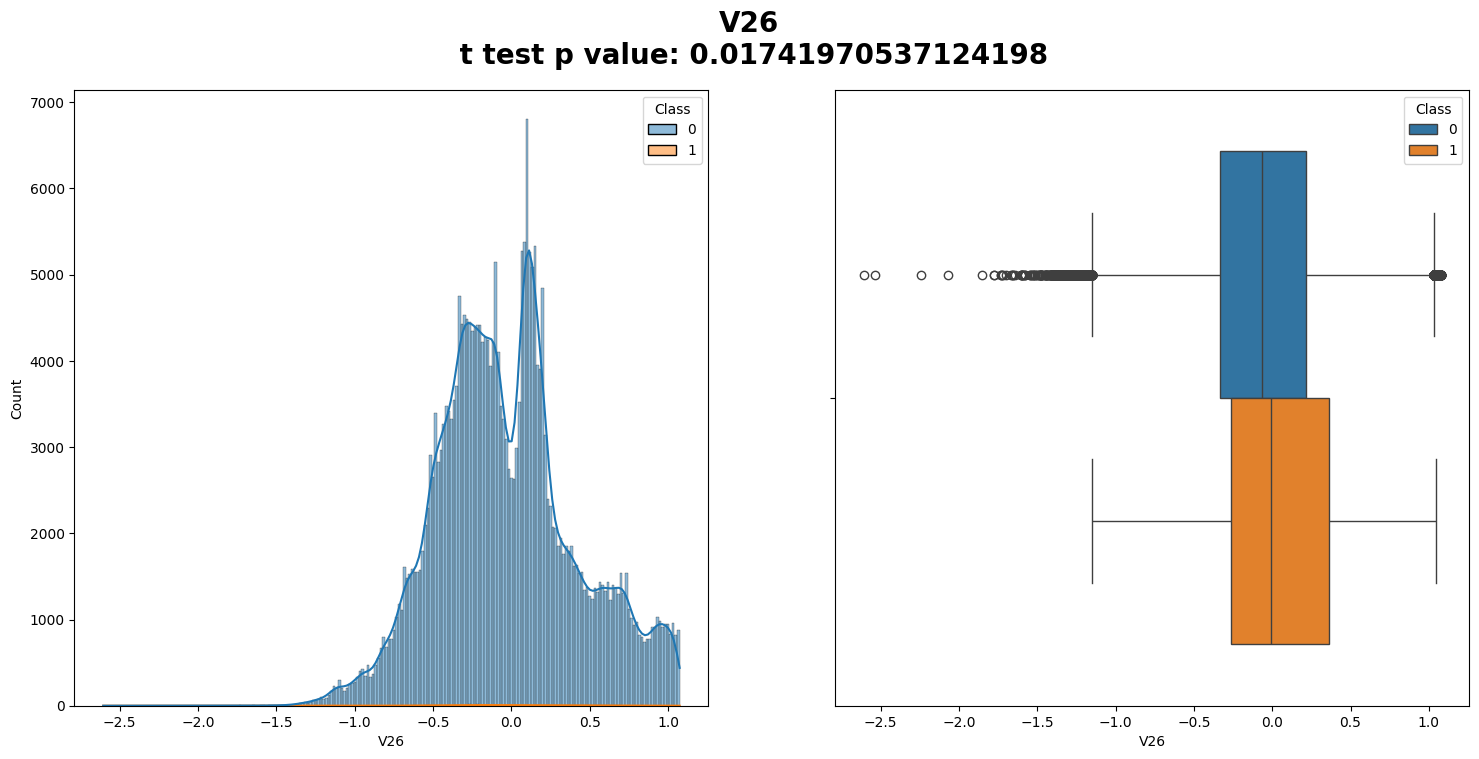

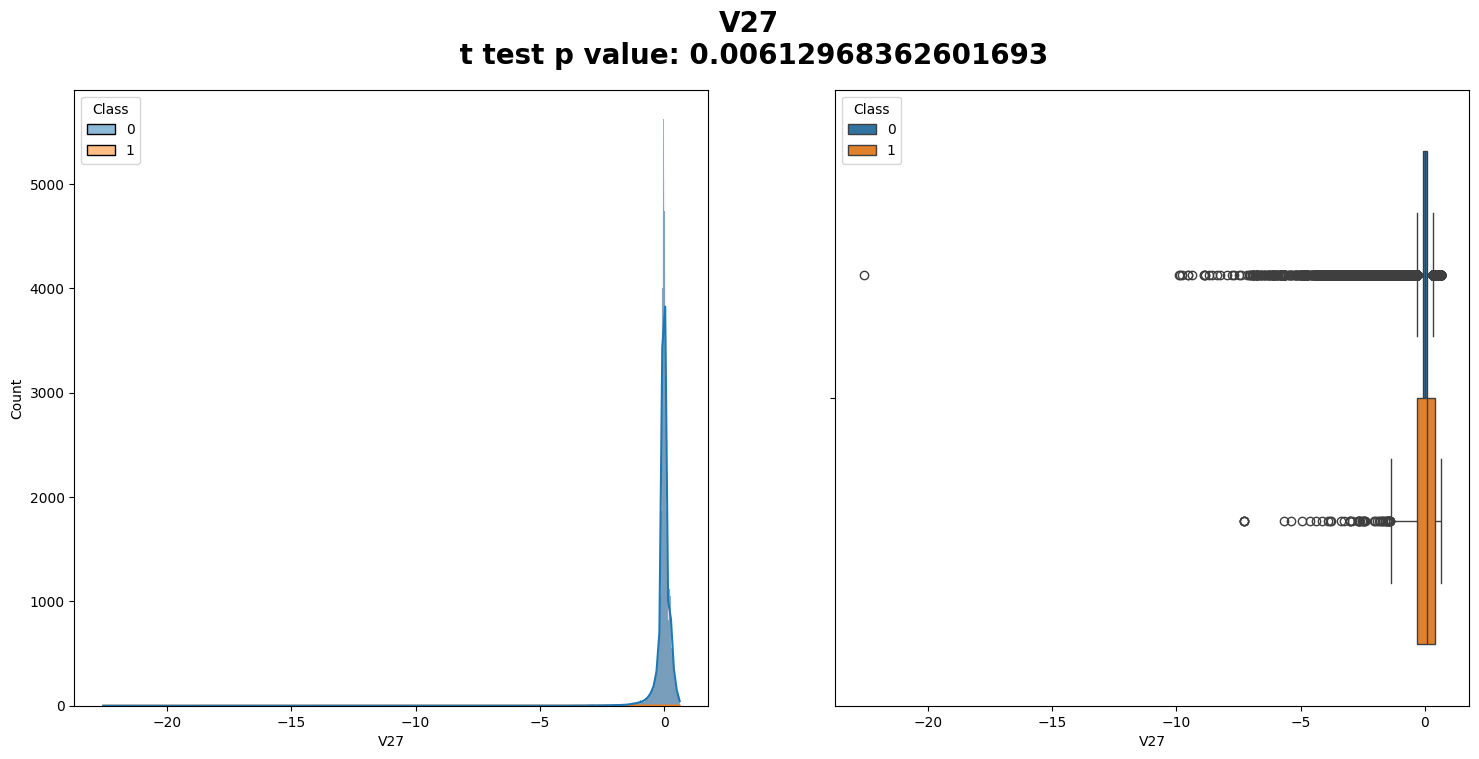

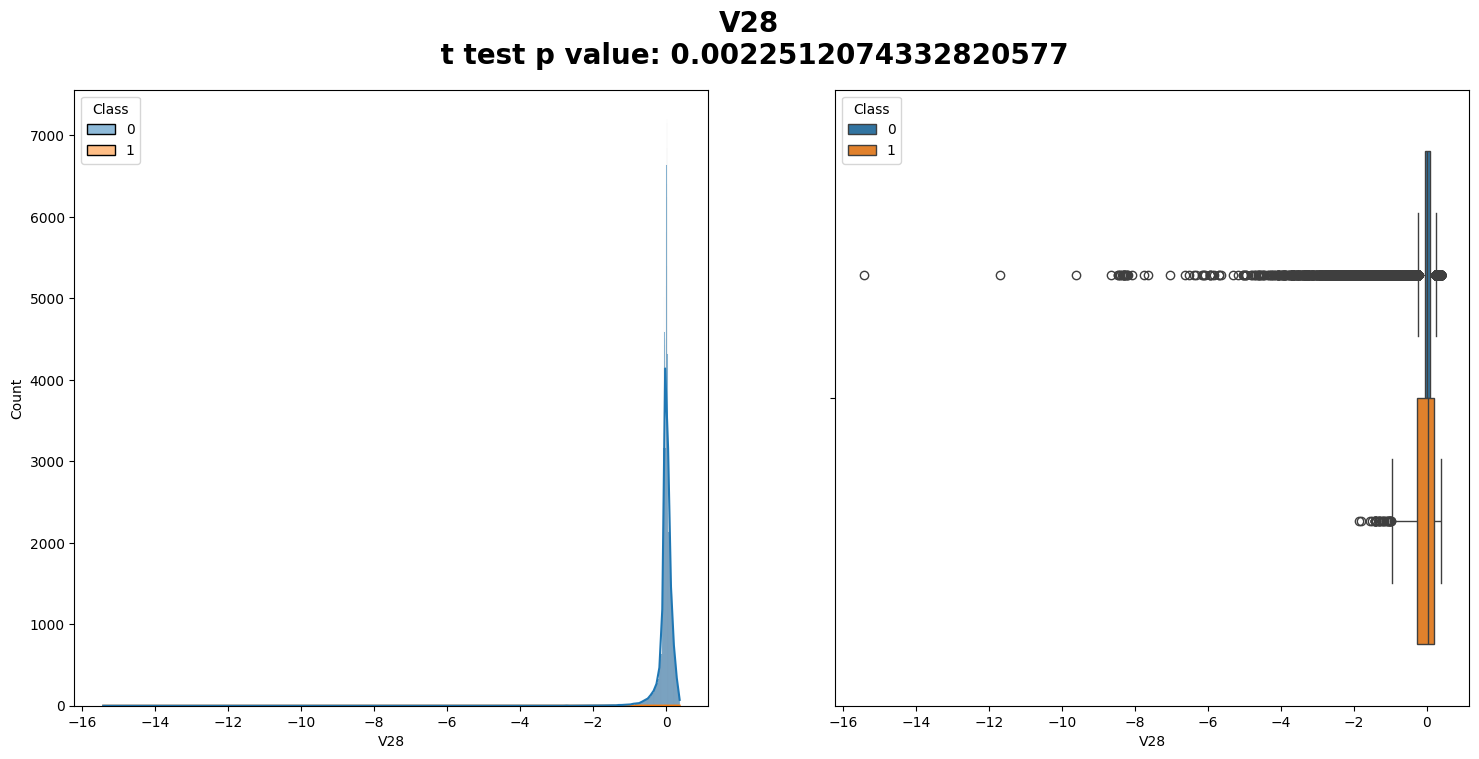

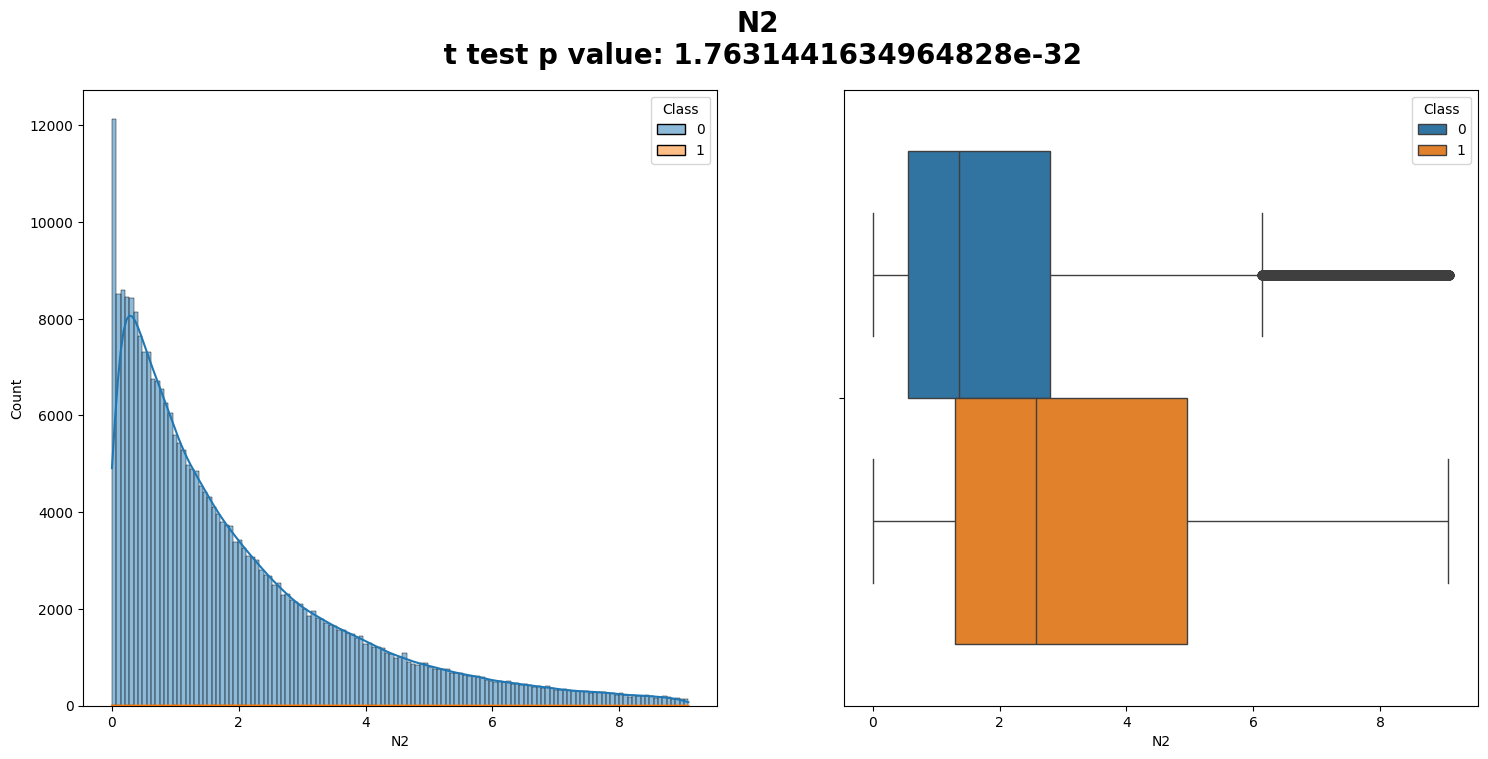

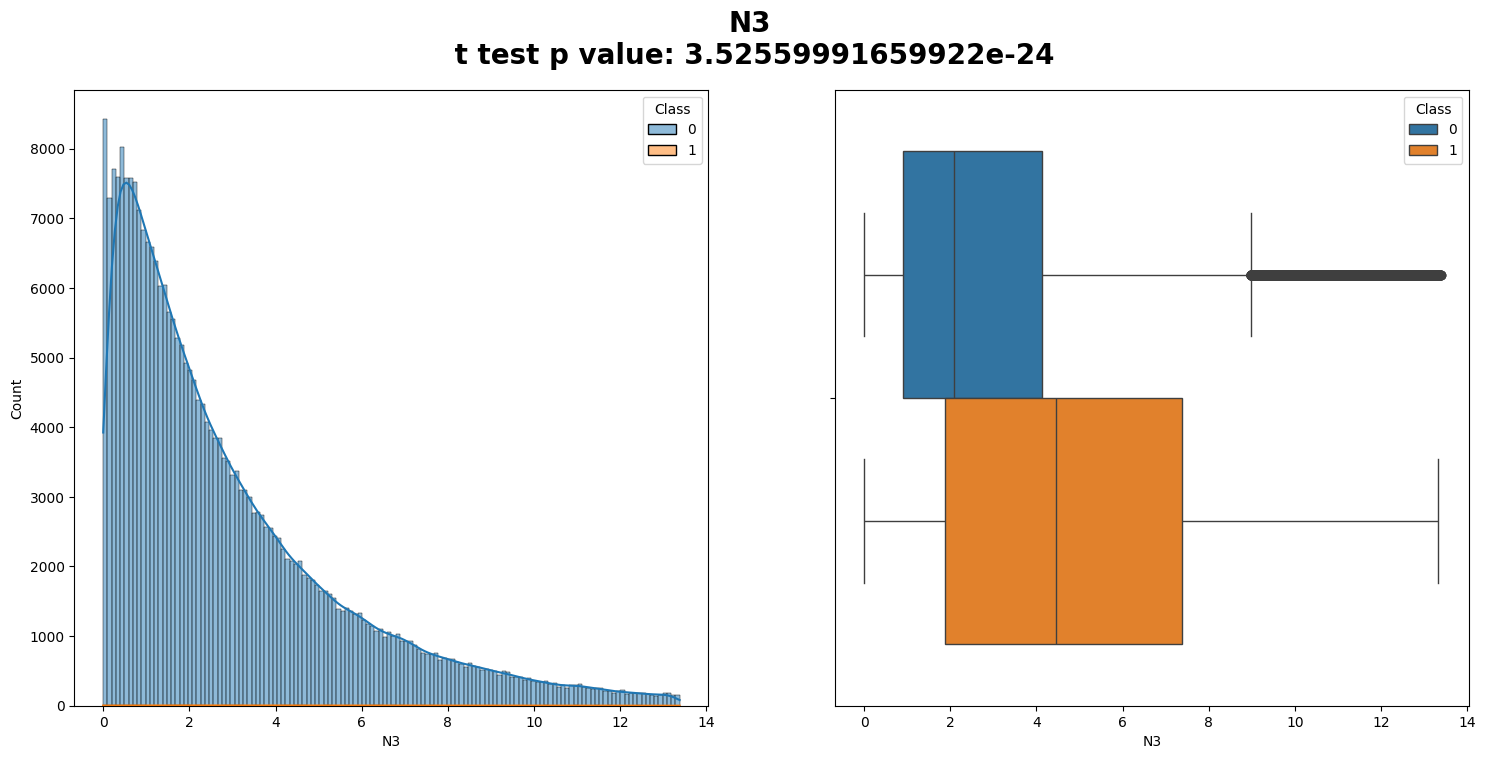

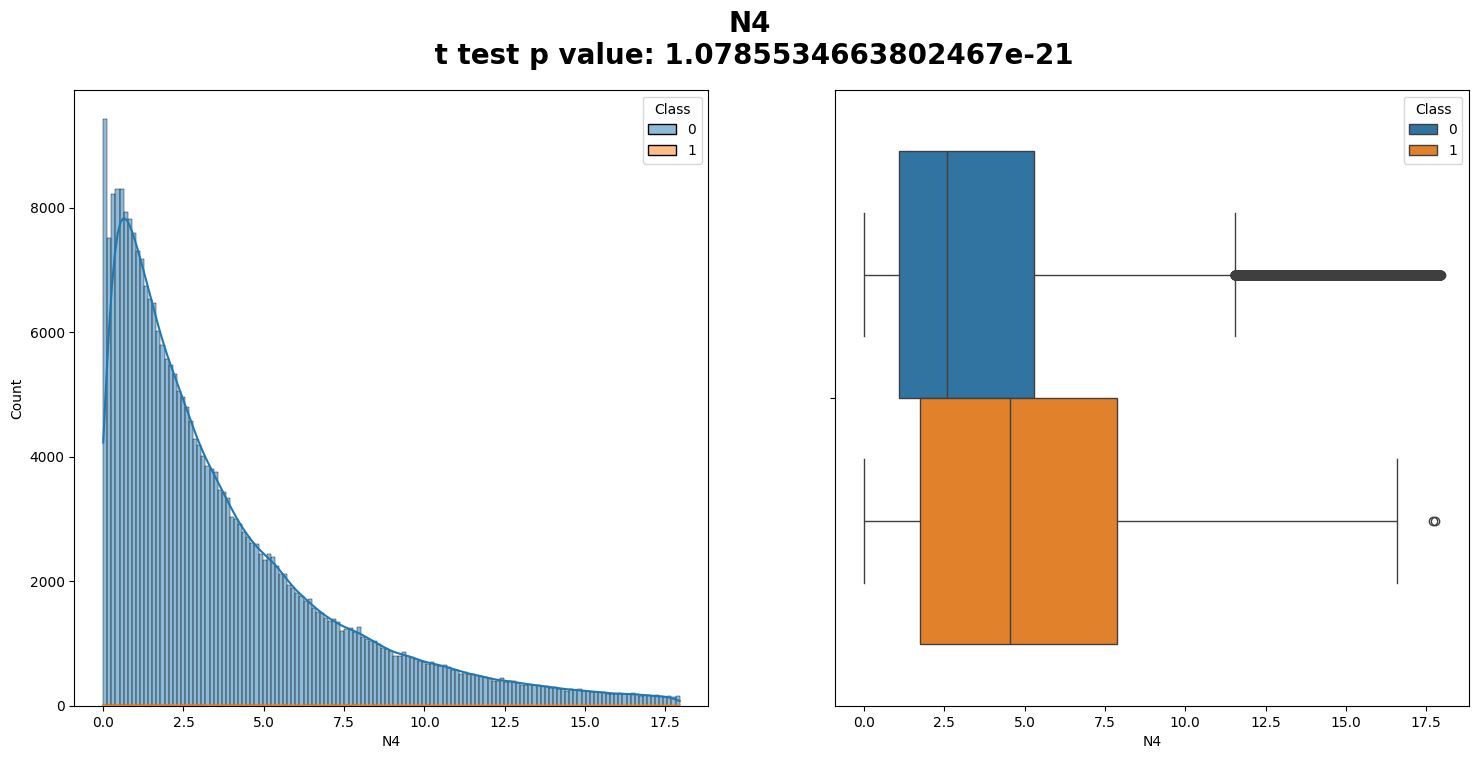

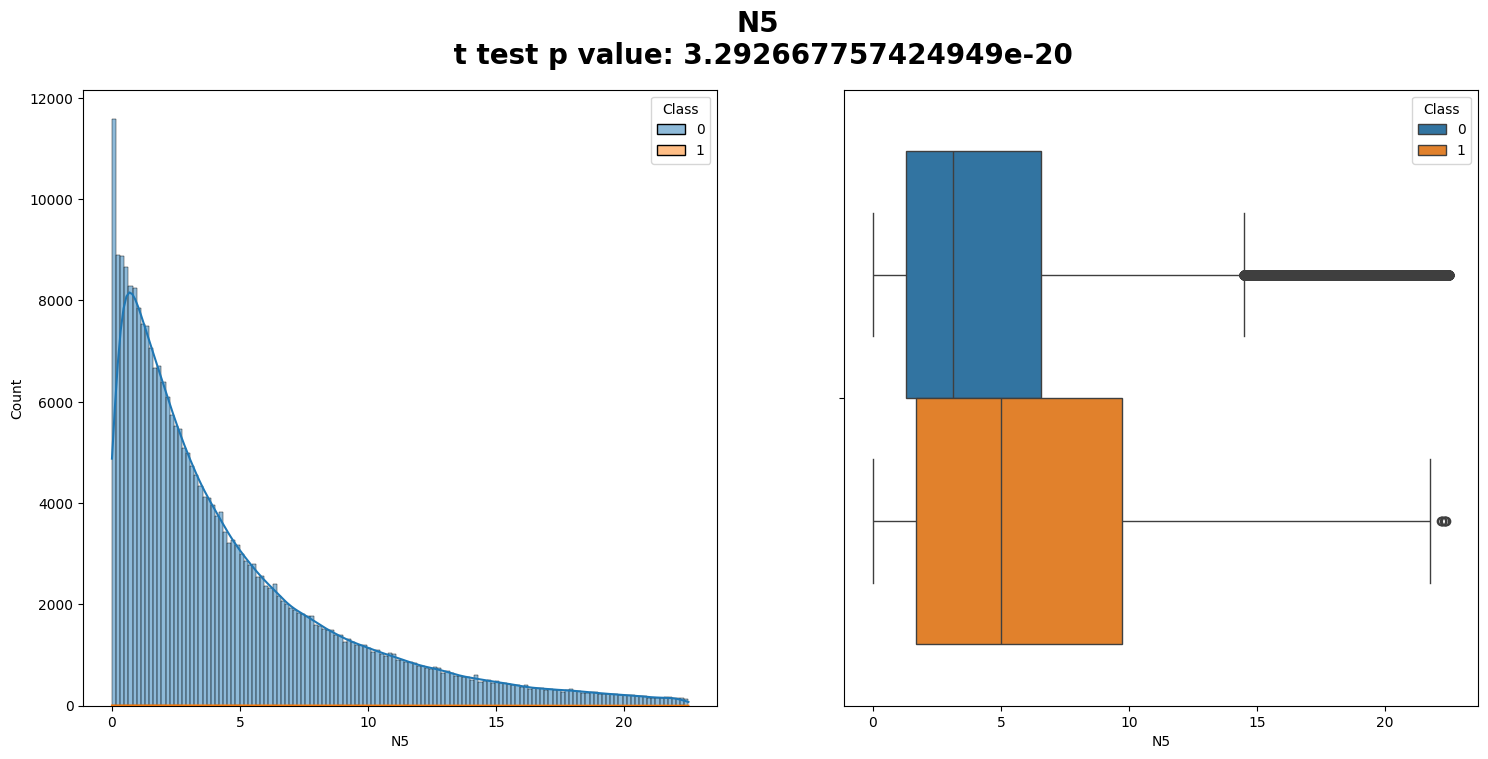

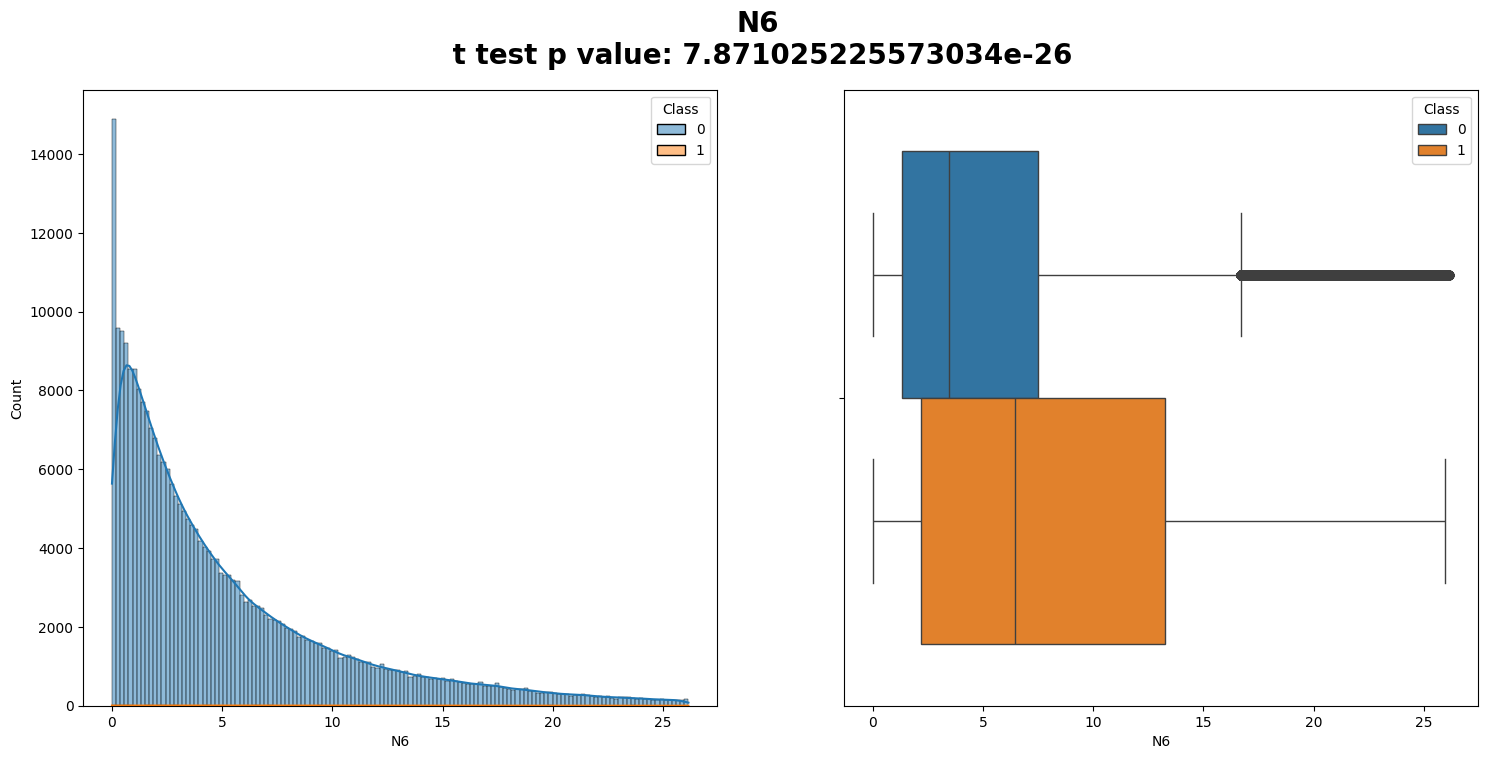

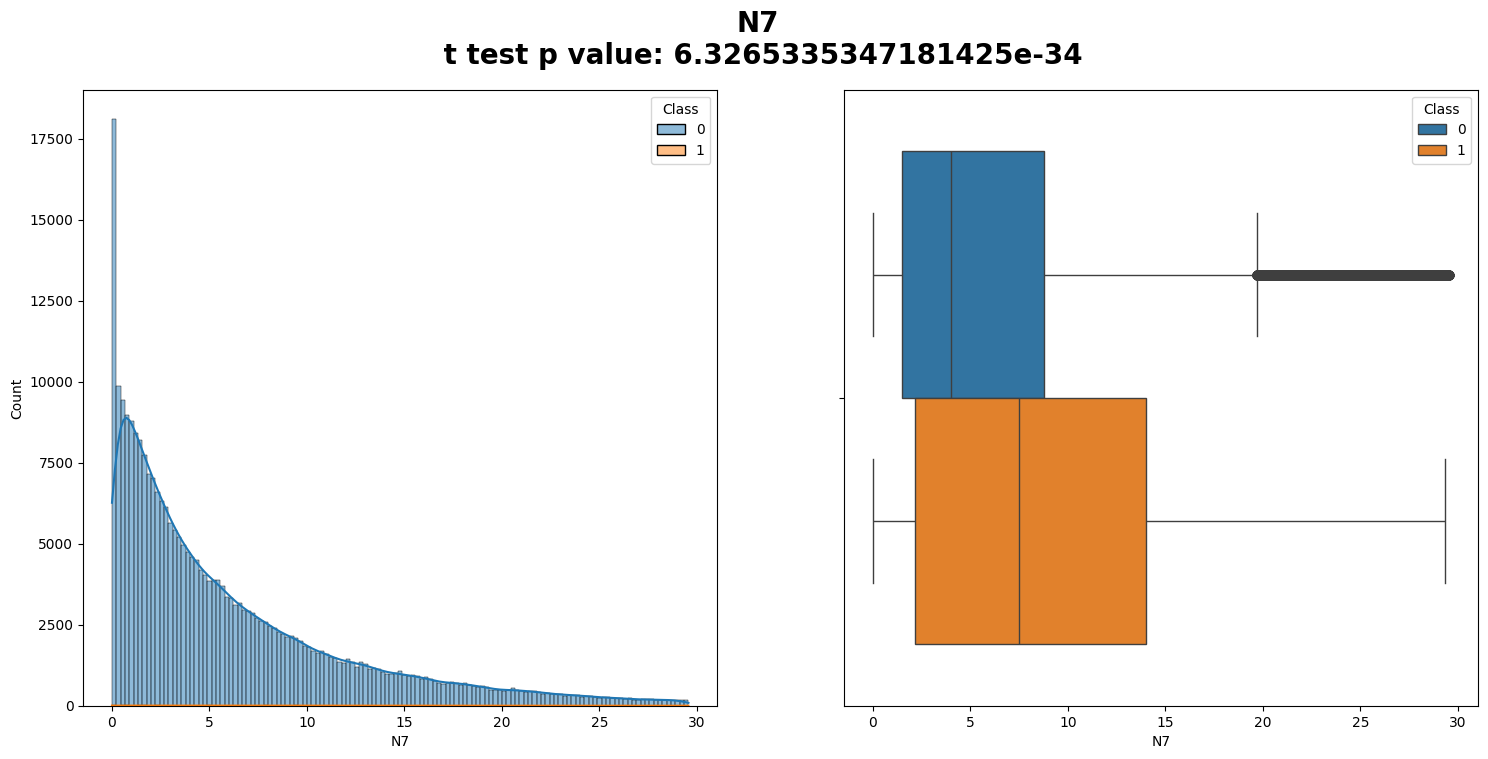

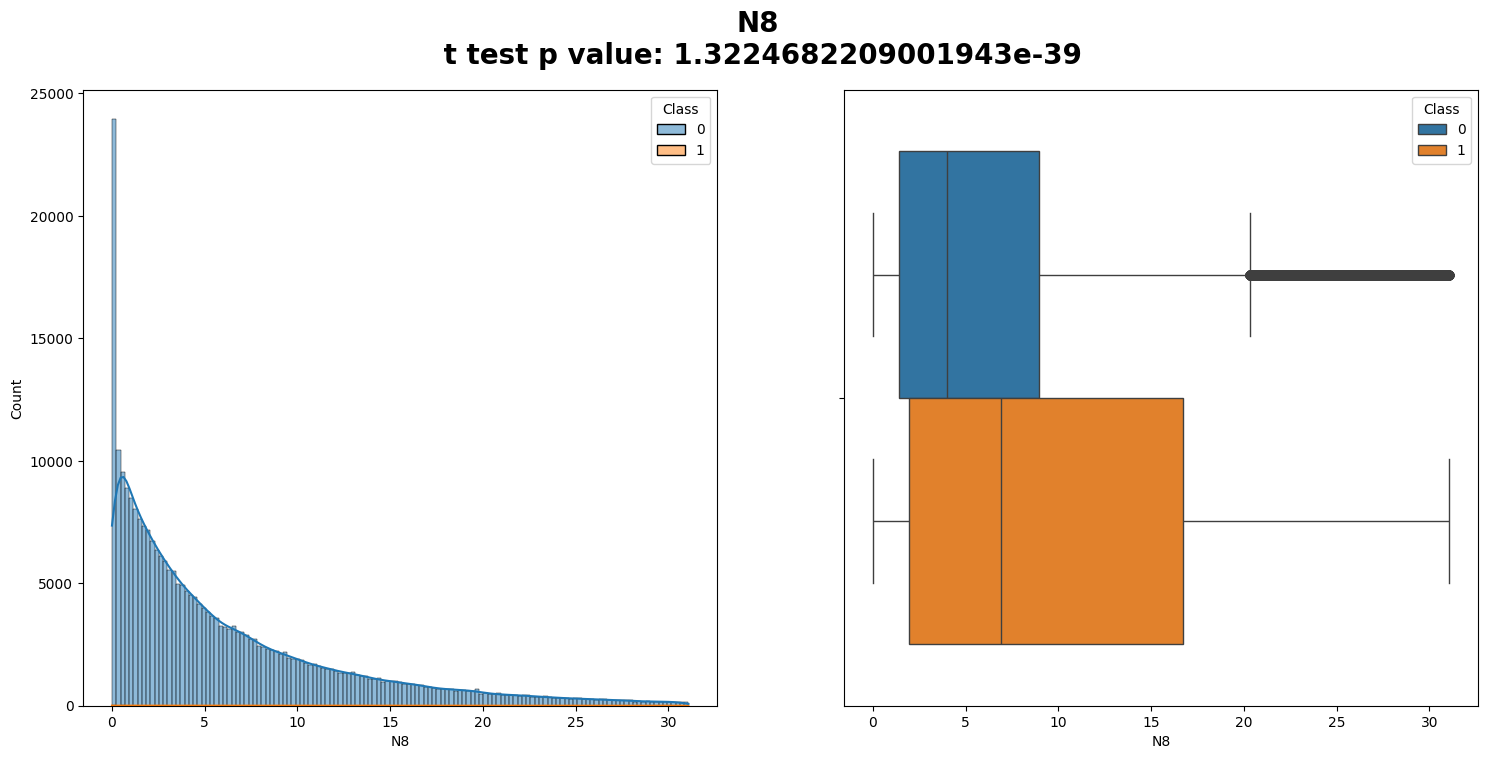

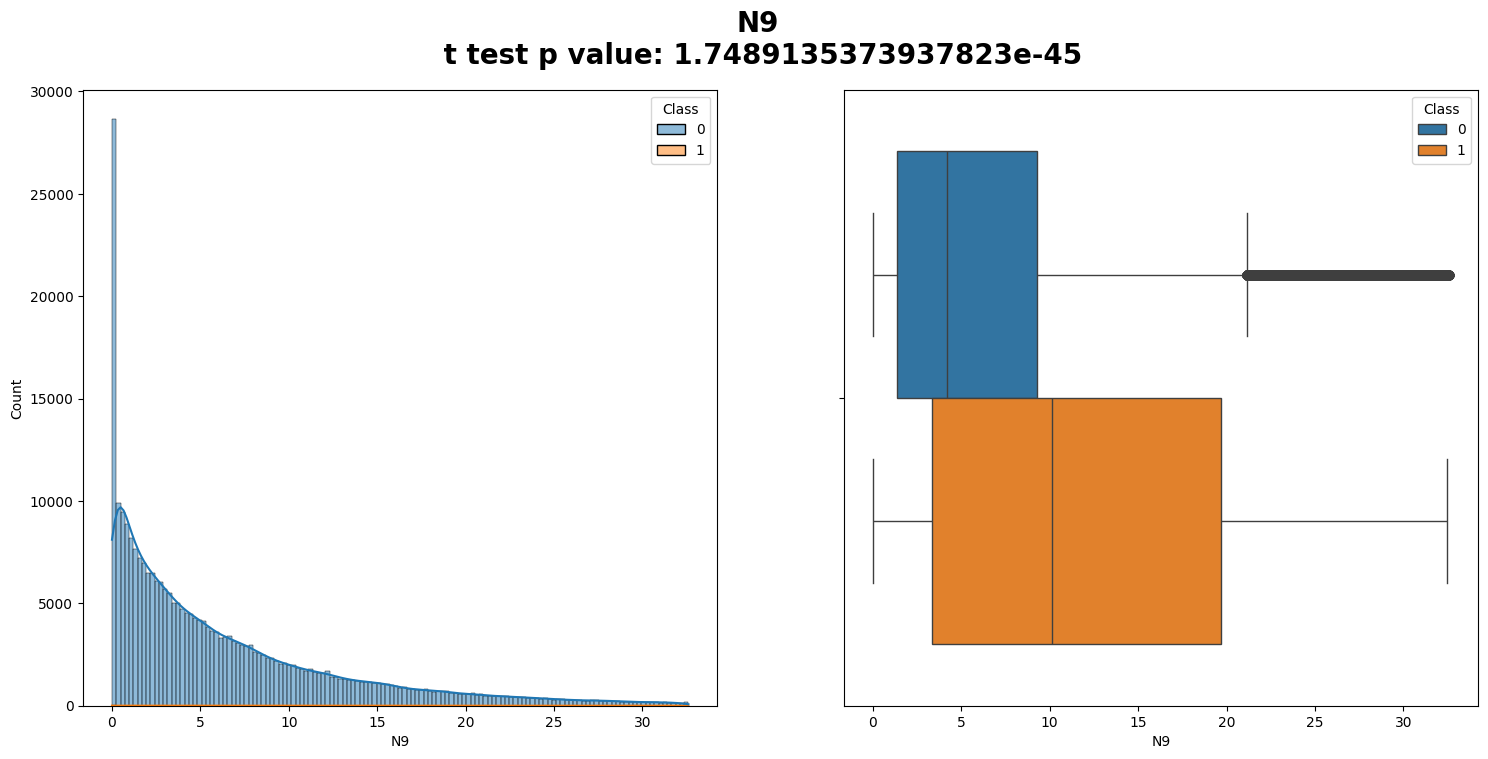

In [31]:
# continuous variables
continuous = ['Time', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9']
for col in continuous:
    plt.figure(figsize = (18, 8))
    plt.suptitle(col + "\n t test p value: " + str(t_test(df, col)['p_value']) , size = 20, fontweight = 'bold')
    plt.subplot(1,2,1)
    sns.histplot(x = col, data=df[df[col] < np.quantile(df[col], .98)], hue = 'Class', kde = True)
    plt.subplot(1,2,2)
    sns.boxplot(x= col, data = df[df[col] < np.quantile(df[col], .98)], hue = 'Class')
    plt.show()

<Axes: >

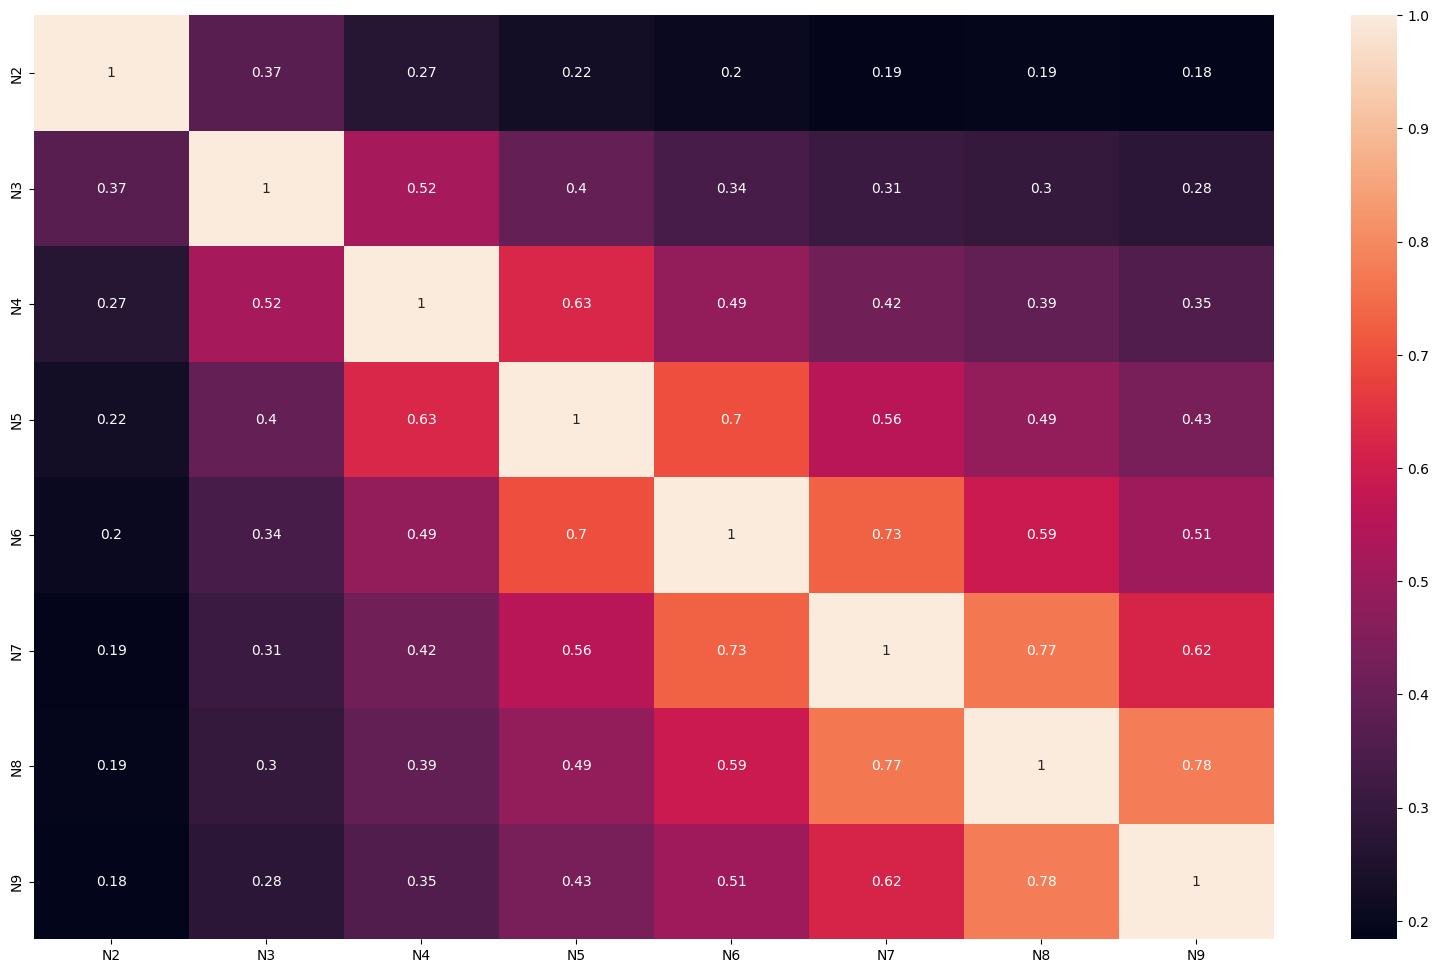

In [32]:
plt.figure(figsize = (20,12))
sns.heatmap(df[['N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9']].corr(), annot = True)

## SMOTETomek to balance the dataset

In [33]:
X = df[['Time', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9']]
y = df['Class'].astype(int)

# 3. Split once for train / test, once again for hold-out valid
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

# 4. Balance *only* the training data with SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

## Initial run to obtain feature importances

[LightGBM] [Info] Number of positive: 204482, number of negative: 204482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 408964, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/var/folders/pj/8bwrwwgx5r9636007br382gm0000gn/T/ipykernel_34500/2528149936.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




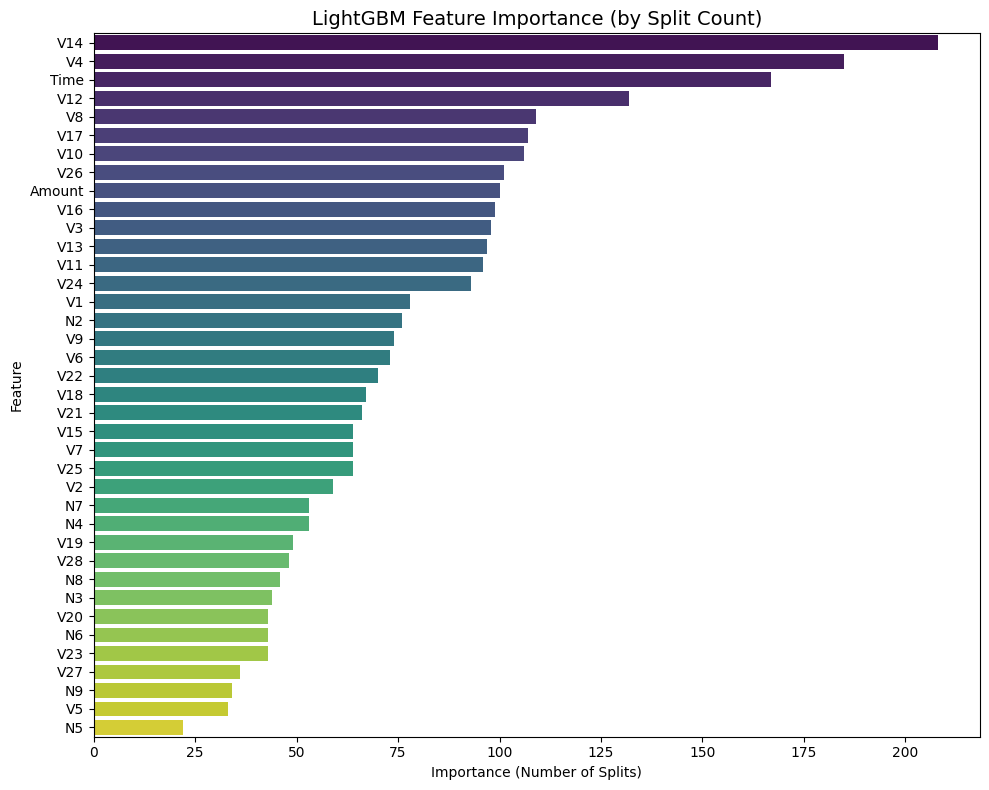

V14, V4, Time, V12, V8, V17, V10, V26, Amount, V16, V3, V13, V11, V24, V1, N2, V9, V6, V22, V18, V21, V15, V7, V25, V2, N7, N4, V19, V28, N8, N3, V20, N6, V23, V27, N9, V5, N5


In [34]:
lgb = LGBMClassifier()
lgb.fit(X_train_balanced,y_train_balanced,
        # early_stopping_rounds=100,
        eval_set=[(X_valid, y_valid), (X_train_balanced, y_train_balanced)])
preds_train = lgb.predict(X_train_balanced)
accuracy_train, recall_train, precision_train, f1_train, auc_train= accuracy_score(y_train_balanced, preds_train), recall_score(y_train_balanced, preds_train), precision_score(y_train_balanced, preds_train), f1_score(y_train_balanced, preds_train), roc_auc_score(y_train_balanced, preds_train)

preds_test = lgb.predict(X_test)
accuracy_test, recall_test, precision_test, f1_test, auc_test = accuracy_score(y_test, preds_test), recall_score(y_test, preds_test), precision_score(y_test, preds_test), f1_score(y_test, preds_test), roc_auc_score(y_test, preds_test)


pd.DataFrame({
    'Metric':['Accuracy', 'Reccall', 'Precision', 'F1', 'AUC'],
    'Train Score' : [accuracy_train,recall_train,precision_train, f1_train,auc_train],
    'Test Score' : [accuracy_test,recall_test,precision_test, f1_test,auc_test],
})

# Get feature importances (by split count) and combine with column names
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb.booster_.feature_importance(importance_type='split')
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance,
    y='Feature',
    x='Importance',
    palette='viridis'
)
plt.title('LightGBM Feature Importance (by Split Count)', fontsize=14)
plt.xlabel('Importance (Number of Splits)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print(*feature_importance['Feature'].tolist(), sep=', ')

## Feature selection from feature importances
- L1 Norms are not as strong as I was hoping, I'm including the strongest norm (N2) along with the other top features

In [35]:
X_train = X_train[['V14', 'Time', 'V4', 'V12','Amount', 'N2']]
X_test = X_test[['V14', 'Time', 'V4', 'V12','Amount', 'N2']]
X_valid = X_valid[['V14', 'Time', 'V4', 'V12','Amount', 'N2']]
X_train_balanced = X_train_balanced[['V14', 'Time', 'V4', 'V12','Amount', 'N2']]

In [36]:
X_train.shape

(205060, 6)

## Hyperparameter tune with Optuna using cross validation and f_beta = 2 for more weight on recall and to reduce false negatives

In [44]:
from sklearn.metrics import make_scorer, fbeta_score


fbeta = make_scorer(fbeta_score, beta=2)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 250),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'random_state': 42,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': -1
    }

    pipeline = Pipeline([
        ('smote', SMOTETomek(random_state=42)),
        ('model', LGBMClassifier(**params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=fbeta, n_jobs=-1)

    return scores.mean()

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Best result
print("Best trial:")
print(study.best_trial.params)


[I 2025-05-22 20:32:00,632] A new study created in memory with name: no-name-892faa81-2adf-4109-8bbe-20e5314b646c
[I 2025-05-22 20:32:25,745] Trial 0 finished with value: 0.6710252478475118 and parameters: {'n_estimators': 145, 'learning_rate': 0.027973332654235156, 'num_leaves': 259, 'max_depth': 43, 'reg_alpha': 0.009018777899607679, 'reg_lambda': 0.0011120764362003454}. Best is trial 0 with value: 0.6710252478475118.
[I 2025-05-22 20:32:43,722] Trial 1 finished with value: 0.4441894443601271 and parameters: {'n_estimators': 95, 'learning_rate': 0.0001824048127421372, 'num_leaves': 983, 'max_depth': 26, 'reg_alpha': 0.00010185430856115546, 'reg_lambda': 1.365828253813104}. Best is trial 0 with value: 0.6710252478475118.
[I 2025-05-22 20:32:50,926] Trial 2 finished with value: 0.7029030206810483 and parameters: {'n_estimators': 87, 'learning_rate': 0.1439098164703064, 'num_leaves': 441, 'max_depth': 9, 'reg_alpha': 2.2245338900552247, 'reg_lambda': 0.006287154087752508}. Best is trial

Best trial:
{'n_estimators': 218, 'learning_rate': 0.1405475948527379, 'num_leaves': 514, 'max_depth': 21, 'reg_alpha': 0.005414794343254522, 'reg_lambda': 0.0001284485405274418}


In [45]:
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_parallel_coordinate(study).show()
vis.plot_slice(study).show()
vis.plot_contour(study).show()

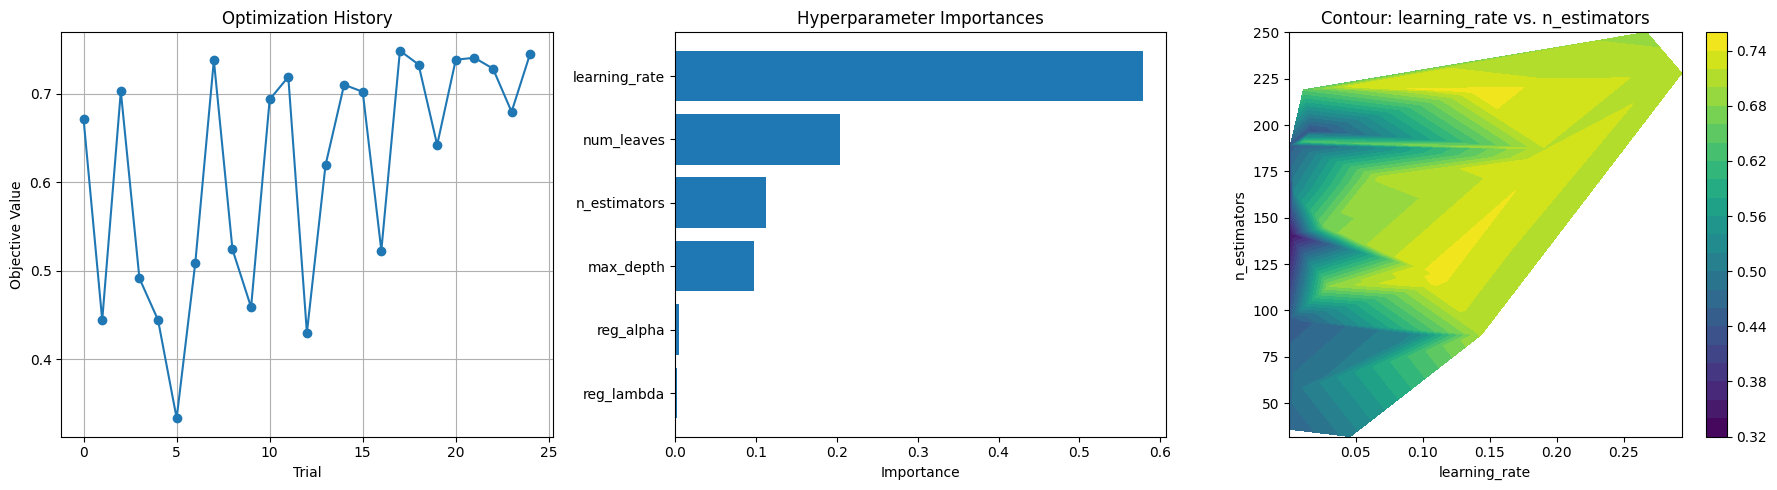

In [46]:
# -- Get optimization history values
values = [t.value for t in study.trials if t.value is not None]

# -- Get param importances
importances = get_param_importances(study)
params = list(importances.keys())
scores = list(importances.values())

# -- For contour plot, extract values for two chosen params
param_x = 'learning_rate'
param_y = 'n_estimators'
x, y, z = [], [], []

for t in study.trials:
    if t.value is None:
        continue
    if param_x in t.params and param_y in t.params:
        x.append(float(t.params[param_x]))
        y.append(int(t.params[param_y]))
        z.append(t.value)

# -- Create contour grid if enough points
has_contour = len(x) > 10

# -- Plot all in one figure
fig = plt.figure(figsize=(18, 5))

# 1. Optimization history
plt.subplot(1, 3, 1)
plt.plot(range(len(values)), values, marker='o')
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History")
plt.grid(True)

# 2. Parameter importances
plt.subplot(1, 3, 2)
plt.barh(params[::-1], scores[::-1])
plt.xlabel("Importance")
plt.title("Hyperparameter Importances")

# 3. Contour plot: learning_rate vs n_estimators
plt.subplot(1, 3, 3)
if has_contour:
    contour = plt.tricontourf(x, y, z, levels=20, cmap='viridis')
    plt.colorbar(contour)
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title("Contour: {} vs. {}".format(param_x, param_y))
else:
    plt.text(0.5, 0.5, "Not enough data for contour plot", ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()


- Apply SmoteTomek in cross validation as shown below to avoid data leakage

In [53]:
# Rebuild pipeline with best params from Optuna
pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42)),
    ('model', LGBMClassifier(**study.best_trial.params, verbose=-1))
])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = {
    'accuracy': cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy').mean(),
    'recall': cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='recall').mean(),
    'precision': cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='precision').mean(),
    'f1': cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='f1').mean(),
    'f2': cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=fbeta).mean(),
    'roc_auc': cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='roc_auc').mean(),
}

print(scores)

{'accuracy': 0.9986345459865404, 'recall': 0.8225352112676058, 'precision': 0.5747189734848415, 'f1': 0.6760213146155308, 'f2': 0.7566584992500061, 'roc_auc': 0.9801065153530792}


## Run on test set

In [55]:
lgb = LGBMClassifier(**study.best_trial.params)
lgb.fit(X_train_balanced, y_train_balanced,
        eval_set=[(X_valid, y_valid), (X_train_balanced, y_train_balanced)])

preds_train = lgb.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, preds_train)
recall_train = recall_score(y_train_balanced, preds_train)
precision_train = precision_score(y_train_balanced, preds_train)
f1_train = f1_score(y_train_balanced, preds_train)
auc_train = roc_auc_score(y_train_balanced, preds_train)
fbeta_train = fbeta_score(y_train_balanced, preds_train, beta=2)

preds_test = lgb.predict(X_test)
accuracy_test = accuracy_score(y_test, preds_test)
recall_test = recall_score(y_test, preds_test)
precision_test = precision_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test)
auc_test = roc_auc_score(y_test, preds_test)
fbeta_test = fbeta_score(y_test, preds_test, beta=2)

pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'F1', 'F2', 'AUC'],
    'Train Score': [accuracy_train, recall_train, precision_train, f1_train, fbeta_train, auc_train],
    'Test Score': [accuracy_test, recall_test, precision_test, f1_test, fbeta_test, auc_test],
})


,Metric,Train Score,Test Score
0,Accuracy,1.0,0.998543
1,Recall,1.0,0.846939
2,Precision,1.0,0.549669
3,F1,1.0,0.666667
4,F2,1.0,0.764273
5,AUC,1.0,0.922871


## Final Feature Importance Chart
- L1 norms (N2) surprisingly was a good predictor for fraud

/var/folders/pj/8bwrwwgx5r9636007br382gm0000gn/T/ipykernel_34500/1916252147.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




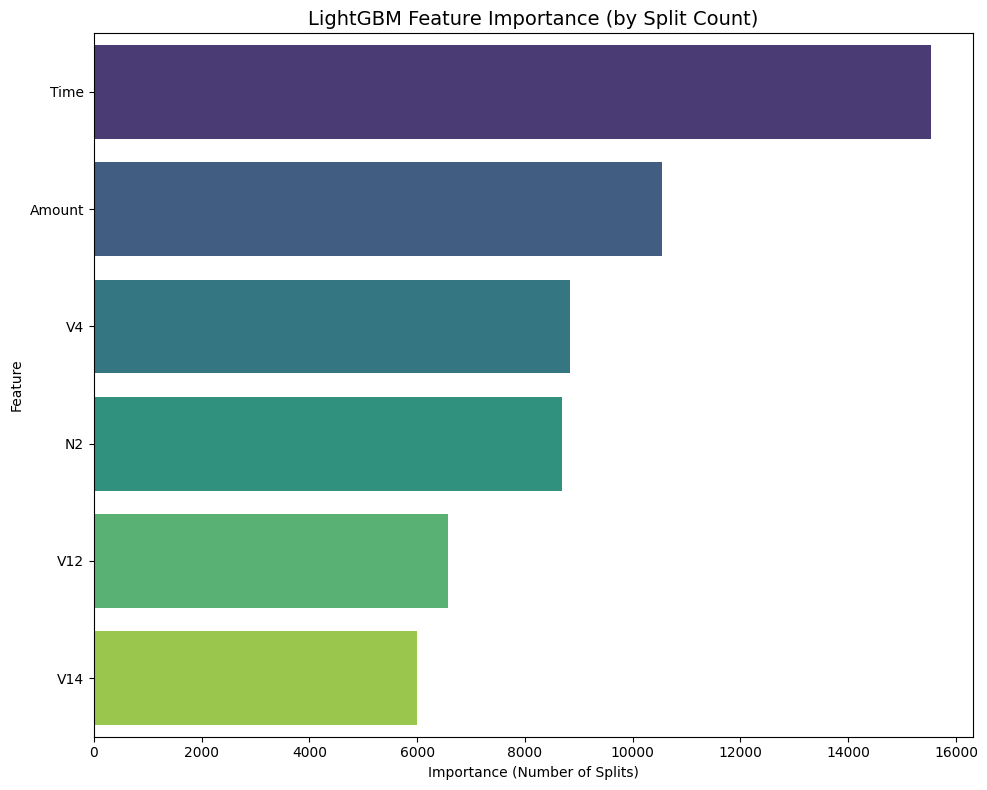

Time, Amount, V4, N2, V12, V14


In [56]:
# Get feature importances (by split count) and combine with column names
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb.booster_.feature_importance(importance_type='split')
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance,
    y='Feature',
    x='Importance',
    palette='viridis'
)
plt.title('LightGBM Feature Importance (by Split Count)', fontsize=14)
plt.xlabel('Importance (Number of Splits)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print(*feature_importance['Feature'].tolist(), sep=', ')

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

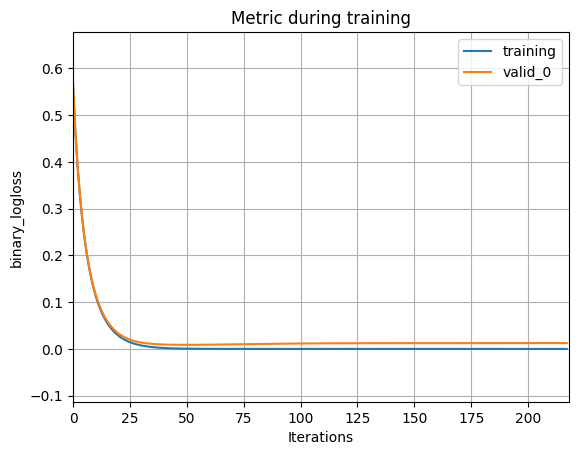

In [57]:
lgbm.plot_metric(lgb)

In [82]:
!jupytext --set-formats ipynb,py creditcardfraud.ipynb --sync

[jupytext] Reading creditcardfraud.ipynb in format ipynb
[jupytext] Updating notebook metadata with '{"jupytext": {"formats": "ipynb,py"}}'
[jupytext] Updating creditcardfraud.ipynb
[jupytext] Updating creditcardfraud.py
